In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import glob
import cv2
import os

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, LSTM, Bidirectional
from tensorflow.keras.models import Model

import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score
import scikitplot as skplt

import pickle
import dill

In [5]:
# filepath = 'session.pkl'
# dill.dump_session(filepath) # Save the session

In [6]:
info = pd.read_csv('data/info.csv', header=None)

In [7]:
# 20 annotation scores per frame for each video 
# each row is a new set of annotation scores of each video, with 20 rows per video
# scores are from 1-5
# 2 second long shot-level importance scores
annotations = pd.read_csv('data/annotations.csv', header=None)

In [8]:
# 20 videos
# 5 videos per category

# VT: Changing Vehicle Tire
# VU: Getting Vehicle Unstuck
# GA: Grooming an Animal
# MS: Making Sandwich
# PK: Parkour
# PR: Parade
# FM: Flash Mob Gathering
# BK: Bee Keeping
# BT: Attempting Bike Tricks
# DS: Dog Show

info = pd.read_csv('data/info.csv')

In [9]:
annotations.rename(columns={0: 'filename', 1: 'category', 2: 'annotations'}, inplace=True)

In [10]:
annotations.head()

,filename,category,annotations
0,AwmHb44_ouw,VT,"4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,..."
1,AwmHb44_ouw,VT,"2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,..."
2,AwmHb44_ouw,VT,"3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,..."
3,AwmHb44_ouw,VT,"4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,..."
4,AwmHb44_ouw,VT,"2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,..."


In [11]:
annotations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
filename       1000 non-null object
category       1000 non-null object
annotations    1000 non-null object
dtypes: object(3)
memory usage: 23.6+ KB


In [12]:
info.head()

,category,video_id,title,url,length
0,VT,AwmHb44_ouw,#1306 How to change tires for off road vehicle...,https://www.youtube.com/watch?v=AwmHb44_ouw,5:54
1,VT,98MoyGZKHXc,How to use a tyre repair kit - Which? guide,https://www.youtube.com/watch?v=98MoyGZKHXc,3:07
2,VT,J0nA4VgnoCo,#0001: FLAT TIRE,https://www.youtube.com/watch?v=J0nA4VgnoCo,9:44
3,VT,gzDbaEs1Rlg,ŠKODA Tips How to Repair Your Tyre,https://www.youtube.com/watch?v=gzDbaEs1Rlg,4:48
4,VT,XzYM3PfTM4w,When to Replace Your Tires GMC,https://www.youtube.com/watch?v=XzYM3PfTM4w,1:51


In [13]:
annotations['annotations'] = annotations['annotations'].apply(lambda a: a.split(','))

In [14]:
avg_annotations = []
for fname in annotations.filename.unique():
    values = annotations[annotations['filename'] == fname]['annotations'].values
    float_conversion = np.array(list(values)).astype('float64') 
    avg = np.mean(float_conversion, axis=0)
    avg_annotations.append(avg)

In [15]:
average_scores = pd.DataFrame({'filename': annotations.filename.unique(), 'average_score': avg_annotations})

In [16]:
average_scores.sort_values(by='filename')

,filename,average_score
49,-esJrBWj2d8,"[1.95, 1.95, 1.95, 1.95, 1.95, 1.95, 1.95, 1.9..."
12,0tmA_C6XwfM,"[1.15, 1.15, 1.15, 1.15, 1.15, 1.15, 1.15, 1.1..."
18,37rzWOQsNIw,"[3.25, 3.25, 3.25, 3.25, 3.25, 3.25, 3.25, 3.2..."
13,3eYKfiOEJNs,"[1.9, 1.9, 1.9, 1.9, 1.9, 1.9, 1.9, 1.9, 1.9, ..."
29,4wU_LUjG5Ic,"[1.95, 1.95, 1.95, 1.95, 1.95, 1.95, 1.95, 1.9..."
25,91IHQYk1IQM,"[1.7, 1.7, 1.7, 1.7, 1.7, 1.7, 1.7, 1.7, 1.7, ..."
1,98MoyGZKHXc,"[1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.7..."
0,AwmHb44_ouw,"[2.9, 2.9, 2.9, 2.9, 2.9, 2.9, 2.9, 2.9, 2.9, ..."
11,Bhxk-O1Y7Ho,"[2.95, 2.95, 2.95, 2.95, 2.95, 2.95, 2.95, 2.9..."
45,E11zDS9XGzg,"[1.65, 1.65, 1.65, 1.65, 1.65, 1.65, 1.65, 1.6..."


In [17]:
info.columns

Index(['category', 'video_id', 'title', 'url', 'length'], dtype='object')

In [18]:
info[info['video_id'] == '-esJrBWj2d8']

,category,video_id,title,url,length
49,DS,-esJrBWj2d8,Will A Cat Eat Dog Food?,https://www.youtube.com/watch?v=-esJrBWj2d8,3:50


In [19]:
info.head()

,category,video_id,title,url,length
0,VT,AwmHb44_ouw,#1306 How to change tires for off road vehicle...,https://www.youtube.com/watch?v=AwmHb44_ouw,5:54
1,VT,98MoyGZKHXc,How to use a tyre repair kit - Which? guide,https://www.youtube.com/watch?v=98MoyGZKHXc,3:07
2,VT,J0nA4VgnoCo,#0001: FLAT TIRE,https://www.youtube.com/watch?v=J0nA4VgnoCo,9:44
3,VT,gzDbaEs1Rlg,ŠKODA Tips How to Repair Your Tyre,https://www.youtube.com/watch?v=gzDbaEs1Rlg,4:48
4,VT,XzYM3PfTM4w,When to Replace Your Tires GMC,https://www.youtube.com/watch?v=XzYM3PfTM4w,1:51


In [20]:
full_df = pd.concat([info.set_index('video_id'), average_scores.set_index('filename')], axis=1, join='inner')

In [21]:
full_df = full_df.reset_index().rename(columns={'index': 'video_id'})

In [22]:
full_df

,video_id,category,title,url,length,average_score
0,AwmHb44_ouw,VT,#1306 How to change tires for off road vehicle...,https://www.youtube.com/watch?v=AwmHb44_ouw,5:54,"[2.9, 2.9, 2.9, 2.9, 2.9, 2.9, 2.9, 2.9, 2.9, ..."
1,98MoyGZKHXc,VT,How to use a tyre repair kit - Which? guide,https://www.youtube.com/watch?v=98MoyGZKHXc,3:07,"[1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.7..."
2,J0nA4VgnoCo,VT,#0001: FLAT TIRE,https://www.youtube.com/watch?v=J0nA4VgnoCo,9:44,"[1.35, 1.35, 1.35, 1.35, 1.35, 1.35, 1.35, 1.3..."
3,gzDbaEs1Rlg,VT,ŠKODA Tips How to Repair Your Tyre,https://www.youtube.com/watch?v=gzDbaEs1Rlg,4:48,"[1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, ..."
4,XzYM3PfTM4w,VT,When to Replace Your Tires GMC,https://www.youtube.com/watch?v=XzYM3PfTM4w,1:51,"[1.7, 1.7, 1.7, 1.7, 1.7, 1.7, 1.7, 1.7, 1.7, ..."
5,HT5vyqe0Xaw,VU,"The stuck truck of Mark, The rut that filled a...",https://www.youtube.com/watch?v=HT5vyqe0Xaw,5:22,"[1.25, 1.25, 1.25, 1.25, 1.25, 1.25, 1.25, 1.2..."
6,sTEELN-vY30,VU,BBC - Train crash 2013,https://www.youtube.com/watch?v=sTEELN-vY30,2:29,"[2.9, 2.9, 2.9, 2.9, 2.9, 2.9, 2.9, 2.9, 2.9, ..."
7,vdmoEJ5YbrQ,VU,#453 girl gets van stuck in the back fourty [D...,https://www.youtube.com/watch?v=vdmoEJ5YbrQ,5:29,"[2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, ..."
8,xwqBXPGE9pQ,VU,Smart Electric Vehicle Balances on Two Wheels,https://www.youtube.com/watch?v=xwqBXPGE9pQ,3:53,"[2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, ..."
9,akI8YFjEmUw,VU,Electric cars making earth more green,https://www.youtube.com/watch?v=akI8YFjEmUw,2:13,"[1.35, 1.35, 1.35, 1.35, 1.35, 1.35, 1.35, 1.3..."


In [23]:
avg_scores_sample = full_df[full_df['video_id'] == 'akI8YFjEmUw']['average_score'].values[0]

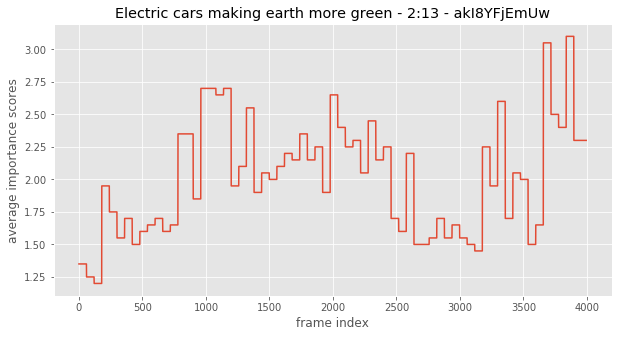

In [24]:
fig, ax = plt.subplots(figsize=(10, 5))
x = range(len(avg_scores_sample))
ax.set_xlabel('frame index')
ax.set_ylabel('average importance scores')
ax.set_title('Electric cars making earth more green - 2:13 - akI8YFjEmUw')
ax.plot(x, avg_scores_sample)

In [25]:
def plot_average_importance_scores(avg_scores, title):
  fig, ax = plt.subplots(figsize=(10, 5))
  x = range(len(avg_scores))
  ax.set_xlabel('frame index')
  ax.set_ylabel('average importance scores')
  ax.set_title(title)
  ax.plot(x, avg_scores)

In [26]:
def sort_frames(list_of_frames, video_id, data_set='train'):
    return sorted(list_of_frames, key=lambda x: int(x.split(f'data/frames/{data_set}/{video_id}/')[1].split('.jpg')[0]))

In [27]:
def rgb_features(image_list, bins):
    features = []
    for frame in image_list:
      cv_img = cv2.imread(frame)
      histr = cv2.calcHist([cv_img], [0, 1, 2], None, [
                           bins, bins, bins], [0, 256, 0, 256, 0, 256])
      cv2.normalize(hist, hist)
      features.append(histr.flatten())
    return features

In [28]:
def hsv_features(image_list, bins):
    features = []
    for frame in image_list:
      cv_img = cv2.imread(frame)
      img = cv2.cvtColor(cv_img, cv2.COLOR_BGR2HSV)
      histr = cv2.calcHist([cv_img], [0, 1, 2], None, [
                           bins, bins, bins], [0, 256, 0, 256, 0, 256])
      cv2.normalize(hist, hist)
      features.append(histr.flatten())
    return features

In [29]:
def get_vgg_features(image_list):
  image_features = []
  base_model = VGG16(weights='imagenet', include_top=False)
  model = Model(inputs=base_model.input,
                outputs=base_model.get_layer('block5_conv3').output)

  for idx, frame in enumerate(image_list):
    img = image.load_img(frame, target_size=(224, 224))
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)

    vgg16_feature = model.predict(img_data)
    image_features.append(np.array(vgg16_feature).flatten())
    print(f'complete for {idx}')

  return image_features

In [30]:
def create_train_or_test_data_set_for_rgb(data_set='train'):
  X = 'first'
  y = 'first'
  for directory in glob.glob(f'data/frames/{data_set}/*'):
      frames = glob.glob(f'{directory}/*')
      video_id = directory.split(f'data/frames/{data_set}/')[1]
      sorted_frames = sort_frames(frames, video_id, data_set=data_set)
      if X == 'first':
          X = rgb_features(sorted_frames, 8)
      else:
          X = np.concatenate(
              (X, rgb_features(sorted_frames, 8)), axis=0)
      scores = average_scores[average_scores['filename'] ==
                              video_id]['average_score'].values[0].reshape(-1, 1)
      if y == 'first':
          y = scores
      else:
          y = np.concatenate((y, scores), axis=0)
      print(f'complete for {video_id}')
      print(np.array(X).shape, np.array(y).shape)
  X = MinMaxScaler(feature_range=(0, 1)).fit_transform(X)
  return X, y

In [31]:
def create_train_or_test_data_set_for_hsv(data_set='train'):
  X = 'first'
  y = 'first'
  for directory in glob.glob(f'data/frames/{data_set}/*'):
      frames = glob.glob(f'{directory}/*')
      video_id = directory.split(f'data/frames/{data_set}/')[1]
      sorted_frames = sort_frames(frames, video_id, data_set=data_set)
      if X == 'first':
          X = hsv_features(sorted_frames, 8)
      else:
          X = np.concatenate(
              (X, rgb_features(sorted_frames, 8)), axis=0)
      scores = average_scores[average_scores['filename'] == video_id]['average_score'].values[0].reshape(-1, 1)
      if y == 'first':
          y = scores
      else:
          y = np.concatenate((y, scores), axis=0)
      print(f'complete for {video_id}')
      print(np.array(X).shape, np.array(y).shape)
  X = MinMaxScaler(feature_range=(0, 1)).fit_transform(X)
  return X, y

In [32]:
def sort_frames(list_of_frames, video_id, data_set='train'):
    return sorted(list_of_frames, key=lambda x: int(x.split(f'data/frames/{data_set}/{video_id}/')[1].split('.jpg')[0]))

In [33]:
def create_train_set_for_vgg(data_set='train'):
  X = 'first'
  y = 'first'
  for directory in glob.glob(f'data/frames/{data_set}/*')[0:18]:
      frames = glob.glob(f'{directory}/*')
      video_id = directory.split(f'data/frames/{data_set}/')[1]
      sorted_frames = sort_frames(frames, video_id, data_set=data_set)
      if X == 'first':
          X = get_vgg_features(sorted_frames)
      else:
          X = np.concatenate((X, get_vgg_features(sorted_frames)))
      print(f'complete for {video_id}')
      print(np.array(X).shape, np.array(y).shape)
  X = MinMaxScaler(feature_range=(0, 1)).fit_transform(X)
  return X

In [ ]:
X_train_vgg = create_train_set_for_vgg(data_set='train')

complete for 0
complete for 1
complete for 2
complete for 3
complete for 4
complete for 5
complete for 6
complete for 7
complete for 8
complete for 9
complete for 10
complete for 11
complete for 12
complete for 13
complete for 14
complete for 15
complete for 16
complete for 17
complete for 18
complete for 19
complete for 20
complete for 21
complete for 22
complete for 23
complete for 24
complete for 25
complete for 26
complete for 27
complete for 28
complete for 29
complete for 30
complete for 31
complete for 32
complete for 33
complete for 34
complete for 35
complete for 36
complete for 37
complete for 38
complete for 39
complete for 40
complete for 41
complete for 42
complete for 43
complete for 44
complete for 45
complete for 46
complete for 47
complete for 48
complete for 49
complete for 50
complete for 51
complete for 52
complete for 53
complete for 54
complete for 55
complete for 56
complete for 57
complete for 58
complete for 59
complete for 60
complete for 61
complete for 62
co

complete for 489
complete for 490
complete for 491
complete for 492
complete for 493
complete for 494
complete for 495
complete for 496
complete for 497
complete for 498
complete for 499
complete for 500
complete for 501
complete for 502
complete for 503
complete for 504
complete for 505
complete for 506
complete for 507
complete for 508
complete for 509
complete for 510
complete for 511
complete for 512
complete for 513
complete for 514
complete for 515
complete for 516
complete for 517
complete for 518
complete for 519
complete for 520
complete for 521
complete for 522
complete for 523
complete for 524
complete for 525
complete for 526
complete for 527
complete for 528
complete for 529
complete for 530
complete for 531
complete for 532
complete for 533
complete for 534
complete for 535
complete for 536
complete for 537
complete for 538
complete for 539
complete for 540
complete for 541
complete for 542
complete for 543
complete for 544
complete for 545
complete for 546
complete for 5

complete for 971
complete for 972
complete for 973
complete for 974
complete for 975
complete for 976
complete for 977
complete for 978
complete for 979
complete for 980
complete for 981
complete for 982
complete for 983
complete for 984
complete for 985
complete for 986
complete for 987
complete for 988
complete for 989
complete for 990
complete for 991
complete for 992
complete for 993
complete for 994
complete for 995
complete for 996
complete for 997
complete for 998
complete for 999
complete for 1000
complete for 1001
complete for 1002
complete for 1003
complete for 1004
complete for 1005
complete for 1006
complete for 1007
complete for 1008
complete for 1009
complete for 1010
complete for 1011
complete for 1012
complete for 1013
complete for 1014
complete for 1015
complete for 1016
complete for 1017
complete for 1018
complete for 1019
complete for 1020
complete for 1021
complete for 1022
complete for 1023
complete for 1024
complete for 1025
complete for 1026
complete for 1027
com

complete for 1429
complete for 1430
complete for 1431
complete for 1432
complete for 1433
complete for 1434
complete for 1435
complete for 1436
complete for 1437
complete for 1438
complete for 1439
complete for 1440
complete for 1441
complete for 1442
complete for 1443
complete for 1444
complete for 1445
complete for 1446
complete for 1447
complete for 1448
complete for 1449
complete for 1450
complete for 1451
complete for 1452
complete for 1453
complete for 1454
complete for 1455
complete for 1456
complete for 1457
complete for 1458
complete for 1459
complete for 1460
complete for 1461
complete for 1462
complete for 1463
complete for 1464
complete for 1465
complete for 1466
complete for 1467
complete for 1468
complete for 1469
complete for 1470
complete for 1471
complete for 1472
complete for 1473
complete for 1474
complete for 1475
complete for 1476
complete for 1477
complete for 1478
complete for 1479
complete for 1480
complete for 1481
complete for 1482
complete for 1483
complete f

complete for 1885
complete for 1886
complete for 1887
complete for 1888
complete for 1889
complete for 1890
complete for 1891
complete for 1892
complete for 1893
complete for 1894
complete for 1895
complete for 1896
complete for 1897
complete for 1898
complete for 1899
complete for 1900
complete for 1901
complete for 1902
complete for 1903
complete for 1904
complete for 1905
complete for 1906
complete for 1907
complete for 1908
complete for 1909
complete for 1910
complete for 1911
complete for 1912
complete for 1913
complete for 1914
complete for 1915
complete for 1916
complete for 1917
complete for 1918
complete for 1919
complete for 1920
complete for 1921
complete for 1922
complete for 1923
complete for 1924
complete for 1925
complete for 1926
complete for 1927
complete for 1928
complete for 1929
complete for 1930
complete for 1931
complete for 1932
complete for 1933
complete for 1934
complete for 1935
complete for 1936
complete for 1937
complete for 1938
complete for 1939
complete f

complete for 2342
complete for 2343
complete for 2344
complete for 2345
complete for 2346
complete for 2347
complete for 2348
complete for 2349
complete for 2350
complete for 2351
complete for 2352
complete for 2353
complete for 2354
complete for 2355
complete for 2356
complete for 2357
complete for 2358
complete for 2359
complete for 2360
complete for 2361
complete for 2362
complete for 2363
complete for 2364
complete for 2365
complete for 2366
complete for 2367
complete for 2368
complete for 2369
complete for 2370
complete for 2371
complete for 2372
complete for 2373
complete for 2374
complete for 2375
complete for 2376
complete for 2377
complete for 2378
complete for 2379
complete for 2380
complete for 2381
complete for 2382
complete for 2383
complete for 2384
complete for 2385
complete for 2386
complete for 2387
complete for 2388
complete for 2389
complete for 2390
complete for 2391
complete for 2392
complete for 2393
complete for 2394
complete for 2395
complete for 2396
complete f

complete for 2798
complete for 2799
complete for 2800
complete for 2801
complete for 2802
complete for 2803
complete for 2804
complete for 2805
complete for 2806
complete for 2807
complete for 2808
complete for 2809
complete for 2810
complete for 2811
complete for 2812
complete for 2813
complete for 2814
complete for 2815
complete for 2816
complete for 2817
complete for 2818
complete for 2819
complete for 2820
complete for 2821
complete for 2822
complete for 2823
complete for 2824
complete for 2825
complete for 2826
complete for 2827
complete for 2828
complete for 2829
complete for 2830
complete for 2831
complete for 2832
complete for 2833
complete for 2834
complete for 2835
complete for 2836
complete for 2837
complete for 2838
complete for 2839
complete for 2840
complete for 2841
complete for 2842
complete for 2843
complete for 2844
complete for 2845
complete for 2846
complete for 2847
complete for 2848
complete for 2849
complete for 2850
complete for 2851
complete for 2852
complete f

complete for 3255
complete for 3256
complete for 3257
complete for 3258
complete for 3259
complete for 3260
complete for 3261
complete for 3262
complete for 3263
complete for 3264
complete for 3265
complete for 3266
complete for 3267
complete for 3268
complete for 3269
complete for 3270
complete for 3271
complete for 3272
complete for 3273
complete for 3274
complete for 3275
complete for 3276
complete for 3277
complete for 3278
complete for 3279
complete for 3280
complete for 3281
complete for 3282
complete for 3283
complete for 3284
complete for 3285
complete for 3286
complete for 3287
complete for 3288
complete for 3289
complete for 3290
complete for 3291
complete for 3292
complete for 3293
complete for 3294
complete for 3295
complete for 3296
complete for 3297
complete for 3298
complete for 3299
complete for 3300
complete for 3301
complete for 3302
complete for 3303
complete for 3304
complete for 3305
complete for 3306
complete for 3307
complete for 3308
complete for 3309
complete f

complete for 3712
complete for 3713
complete for 3714
complete for 3715
complete for 3716
complete for 3717
complete for 3718
complete for 3719
complete for 3720
complete for 3721
complete for 3722
complete for 3723
complete for 3724
complete for 3725
complete for 3726
complete for 3727
complete for 3728
complete for 3729
complete for 3730
complete for 3731
complete for 3732
complete for 3733
complete for 3734
complete for 3735
complete for 3736
complete for 3737
complete for 3738
complete for 3739
complete for 3740
complete for 3741
complete for 3742
complete for 3743
complete for 3744
complete for 3745
complete for 3746
complete for 3747
complete for 3748
complete for 3749
complete for 3750
complete for 3751
complete for 3752
complete for 3753
complete for 3754
complete for 3755
complete for 3756
complete for 3757
complete for 3758
complete for 3759
complete for 3760
complete for 3761
complete for 3762
complete for 3763
complete for 3764
complete for 3765
complete for 3766
complete f

complete for 4168
complete for 4169
complete for 4170
complete for 4171
complete for 4172
complete for 4173
complete for 4174
complete for 4175
complete for 4176
complete for 4177
complete for 4178
complete for 4179
complete for 4180
complete for 4181
complete for 4182
complete for 4183
complete for 4184
complete for 4185
complete for 4186
complete for 4187
complete for 4188
complete for 4189
complete for 4190
complete for 4191
complete for 4192
complete for 4193
complete for 4194
complete for 4195
complete for 4196
complete for 4197
complete for 4198
complete for 4199
complete for 4200
complete for 4201
complete for 4202
complete for 4203
complete for 4204
complete for 4205
complete for 4206
complete for 4207
complete for 4208
complete for 4209
complete for 4210
complete for 4211
complete for 4212
complete for 4213
complete for 4214
complete for 4215
complete for 4216
complete for 4217
complete for 4218
complete for 4219
complete for 4220
complete for 4221
complete for 4222
complete f

complete for 169
complete for 170
complete for 171
complete for 172
complete for 173
complete for 174
complete for 175
complete for 176
complete for 177
complete for 178
complete for 179
complete for 180
complete for 181
complete for 182
complete for 183
complete for 184
complete for 185
complete for 186
complete for 187
complete for 188
complete for 189
complete for 190
complete for 191
complete for 192
complete for 193
complete for 194
complete for 195
complete for 196
complete for 197
complete for 198
complete for 199
complete for 200
complete for 201
complete for 202
complete for 203
complete for 204
complete for 205
complete for 206
complete for 207
complete for 208
complete for 209
complete for 210
complete for 211
complete for 212
complete for 213
complete for 214
complete for 215
complete for 216
complete for 217
complete for 218
complete for 219
complete for 220
complete for 221
complete for 222
complete for 223
complete for 224
complete for 225
complete for 226
complete for 2

complete for 652
complete for 653
complete for 654
complete for 655
complete for 656
complete for 657
complete for 658
complete for 659
complete for 660
complete for 661
complete for 662
complete for 663
complete for 664
complete for 665
complete for 666
complete for 667
complete for 668
complete for 669
complete for 670
complete for 671
complete for 672
complete for 673
complete for 674
complete for 675
complete for 676
complete for 677
complete for 678
complete for 679
complete for 680
complete for 681
complete for 682
complete for 683
complete for 684
complete for 685
complete for 686
complete for 687
complete for 688
complete for 689
complete for 690
complete for 691
complete for 692
complete for 693
complete for 694
complete for 695
complete for 696
complete for 697
complete for 698
complete for 699
complete for 700
complete for 701
complete for 702
complete for 703
complete for 704
complete for 705
complete for 706
complete for 707
complete for 708
complete for 709
complete for 7

complete for 1128
complete for 1129
complete for 1130
complete for 1131
complete for 1132
complete for 1133
complete for 1134
complete for 1135
complete for 1136
complete for 1137
complete for 1138
complete for 1139
complete for 1140
complete for 1141
complete for 1142
complete for 1143
complete for 1144
complete for 1145
complete for 1146
complete for 1147
complete for 1148
complete for 1149
complete for 1150
complete for 1151
complete for 1152
complete for 1153
complete for 1154
complete for 1155
complete for 1156
complete for 1157
complete for 1158
complete for 1159
complete for 1160
complete for 1161
complete for 1162
complete for 1163
complete for 1164
complete for 1165
complete for 1166
complete for 1167
complete for 1168
complete for 1169
complete for 1170
complete for 1171
complete for 1172
complete for 1173
complete for 1174
complete for 1175
complete for 1176
complete for 1177
complete for 1178
complete for 1179
complete for 1180
complete for 1181
complete for 1182
complete f

complete for 1585
complete for 1586
complete for 1587
complete for 1588
complete for 1589
complete for 1590
complete for 1591
complete for 1592
complete for 1593
complete for 1594
complete for 1595
complete for 1596
complete for 1597
complete for 1598
complete for 1599
complete for 1600
complete for 1601
complete for 1602
complete for 1603
complete for 1604
complete for 1605
complete for 1606
complete for 1607
complete for 1608
complete for 1609
complete for 1610
complete for 1611
complete for 1612
complete for 1613
complete for 1614
complete for 1615
complete for 1616
complete for 1617
complete for 1618
complete for 1619
complete for 1620
complete for 1621
complete for 1622
complete for 1623
complete for 1624
complete for 1625
complete for 1626
complete for 1627
complete for 1628
complete for 1629
complete for 1630
complete for 1631
complete for 1632
complete for 1633
complete for 1634
complete for 1635
complete for 1636
complete for 1637
complete for 1638
complete for 1639
complete f

complete for 2041
complete for 2042
complete for 2043
complete for 2044
complete for 2045
complete for 2046
complete for 2047
complete for 2048
complete for 2049
complete for 2050
complete for 2051
complete for 2052
complete for 2053
complete for 2054
complete for 2055
complete for 2056
complete for 2057
complete for 2058
complete for 2059
complete for 2060
complete for 2061
complete for 2062
complete for 2063
complete for 2064
complete for 2065
complete for 2066
complete for 2067
complete for 2068
complete for 2069
complete for 2070
complete for 2071
complete for 2072
complete for 2073
complete for 2074
complete for 2075
complete for 2076
complete for 2077
complete for 2078
complete for 2079
complete for 2080
complete for 2081
complete for 2082
complete for 2083
complete for 2084
complete for 2085
complete for 2086
complete for 2087
complete for 2088
complete for 2089
complete for 2090
complete for 2091
complete for 2092
complete for 2093
complete for 2094
complete for 2095
complete f

complete for 2498
complete for 2499
complete for 2500
complete for 2501
complete for 2502
complete for 2503
complete for 2504
complete for 2505
complete for 2506
complete for 2507
complete for 2508
complete for 2509
complete for 2510
complete for 2511
complete for 2512
complete for 2513
complete for 2514
complete for 2515
complete for 2516
complete for 2517
complete for 2518
complete for 2519
complete for 2520
complete for 2521
complete for 2522
complete for 2523
complete for 2524
complete for 2525
complete for 2526
complete for 2527
complete for 2528
complete for 2529
complete for 2530
complete for 2531
complete for 2532
complete for 2533
complete for 2534
complete for 2535
complete for 2536
complete for 2537
complete for 2538
complete for 2539
complete for 2540
complete for 2541
complete for 2542
complete for 2543
complete for 2544
complete for 2545
complete for 2546
complete for 2547
complete for 2548
complete for 2549
complete for 2550
complete for 2551
complete for 2552
complete f

complete for 2954
complete for 2955
complete for 2956
complete for 2957
complete for 2958
complete for 2959
complete for 2960
complete for 2961
complete for 2962
complete for 2963
complete for 2964
complete for 2965
complete for 2966
complete for 2967
complete for 2968
complete for 2969
complete for 2970
complete for 2971
complete for 2972
complete for 2973
complete for 2974
complete for 2975
complete for 2976
complete for 2977
complete for 2978
complete for 2979
complete for 2980
complete for 2981
complete for 2982
complete for 2983
complete for 2984
complete for 2985
complete for 2986
complete for 2987
complete for 2988
complete for 2989
complete for 2990
complete for 2991
complete for 2992
complete for 2993
complete for 2994
complete for 2995
complete for 2996
complete for 2997
complete for 2998
complete for 2999
complete for 3000
complete for 3001
complete for 3002
complete for 3003
complete for 3004
complete for 3005
complete for 3006
complete for 3007
complete for 3008
complete f

complete for 3411
complete for 3412
complete for 3413
complete for 3414
complete for 3415
complete for 3416
complete for 3417
complete for 3418
complete for 3419
complete for 3420
complete for 3421
complete for 3422
complete for 3423
complete for 3424
complete for 3425
complete for 3426
complete for 3427
complete for 3428
complete for 3429
complete for 3430
complete for 3431
complete for 3432
complete for 3433
complete for 3434
complete for 3435
complete for 3436
complete for 3437
complete for 3438
complete for 3439
complete for 3440
complete for 3441
complete for 3442
complete for 3443
complete for 3444
complete for 3445
complete for 3446
complete for 3447
complete for 3448
complete for 3449
complete for 3450
complete for 3451
complete for 3452
complete for 3453
complete for 3454
complete for 3455
complete for 3456
complete for 3457
complete for 3458
complete for 3459
complete for 3460
complete for 3461
complete for 3462
complete for 3463
complete for 3464
complete for 3465
complete f

complete for 3868
complete for 3869
complete for 3870
complete for 3871
complete for 3872
complete for 3873
complete for 3874
complete for 3875
complete for 3876
complete for 3877
complete for 3878
complete for 3879
complete for 3880
complete for 3881
complete for 3882
complete for 3883
complete for 3884
complete for 3885
complete for 3886
complete for 3887
complete for 3888
complete for 3889
complete for 3890
complete for 3891
complete for 3892
complete for 3893
complete for 3894
complete for 3895
complete for 3896
complete for 3897
complete for 3898
complete for 3899
complete for 3900
complete for 3901
complete for 3902
complete for 3903
complete for 3904
complete for 3905
complete for 3906
complete for 3907
complete for 3908
complete for 3909
complete for 3910
complete for 3911
complete for 3912
complete for 3913
complete for 3914
complete for 3915
complete for 3916
complete for 3917
complete for 3918
complete for 3919
complete for 3920
complete for 3921
complete for 3922
complete f

/Users/sachin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  


complete for 0
complete for 1
complete for 2
complete for 3
complete for 4
complete for 5
complete for 6
complete for 7
complete for 8
complete for 9
complete for 10
complete for 11
complete for 12
complete for 13
complete for 14
complete for 15
complete for 16
complete for 17
complete for 18
complete for 19
complete for 20
complete for 21
complete for 22
complete for 23
complete for 24
complete for 25
complete for 26
complete for 27
complete for 28
complete for 29
complete for 30
complete for 31
complete for 32
complete for 33
complete for 34
complete for 35
complete for 36
complete for 37
complete for 38
complete for 39
complete for 40
complete for 41
complete for 42
complete for 43
complete for 44
complete for 45
complete for 46
complete for 47
complete for 48
complete for 49
complete for 50
complete for 51
complete for 52
complete for 53
complete for 54
complete for 55
complete for 56
complete for 57
complete for 58
complete for 59
complete for 60
complete for 61
complete for 62
co

complete for 489
complete for 490
complete for 491
complete for 492
complete for 493
complete for 494
complete for 495
complete for 496
complete for 497
complete for 498
complete for 499
complete for 500
complete for 501
complete for 502
complete for 503
complete for 504
complete for 505
complete for 506
complete for 507
complete for 508
complete for 509
complete for 510
complete for 511
complete for 512
complete for 513
complete for 514
complete for 515
complete for 516
complete for 517
complete for 518
complete for 519
complete for 520
complete for 521
complete for 522
complete for 523
complete for 524
complete for 525
complete for 526
complete for 527
complete for 528
complete for 529
complete for 530
complete for 531
complete for 532
complete for 533
complete for 534
complete for 535
complete for 536
complete for 537
complete for 538
complete for 539
complete for 540
complete for 541
complete for 542
complete for 543
complete for 544
complete for 545
complete for 546
complete for 5

complete for 972
complete for 973
complete for 974
complete for 975
complete for 976
complete for 977
complete for 978
complete for 979
complete for 980
complete for 981
complete for 982
complete for 983
complete for 984
complete for 985
complete for 986
complete for 987
complete for 988
complete for 989
complete for 990
complete for 991
complete for 992
complete for 993
complete for 994
complete for 995
complete for 996
complete for 997
complete for 998
complete for 999
complete for 1000
complete for 1001
complete for 1002
complete for 1003
complete for 1004
complete for 1005
complete for 1006
complete for 1007
complete for 1008
complete for 1009
complete for 1010
complete for 1011
complete for 1012
complete for 1013
complete for 1014
complete for 1015
complete for 1016
complete for 1017
complete for 1018
complete for 1019
complete for 1020
complete for 1021
complete for 1022
complete for 1023
complete for 1024
complete for 1025
complete for 1026
complete for 1027
complete for 1028
co

complete for 1429
complete for 1430
complete for 1431
complete for 1432
complete for 1433
complete for 1434
complete for 1435
complete for 1436
complete for 1437
complete for 1438
complete for 1439
complete for 1440
complete for 1441
complete for 1442
complete for 1443
complete for 1444
complete for 1445
complete for 1446
complete for 1447
complete for 1448
complete for 1449
complete for 1450
complete for 1451
complete for 1452
complete for 1453
complete for 1454
complete for 1455
complete for 1456
complete for 1457
complete for 1458
complete for 1459
complete for 1460
complete for 1461
complete for 1462
complete for 1463
complete for 1464
complete for 1465
complete for 1466
complete for 1467
complete for 1468
complete for 1469
complete for 1470
complete for 1471
complete for 1472
complete for 1473
complete for 1474
complete for 1475
complete for 1476
complete for 1477
complete for 1478
complete for 1479
complete for 1480
complete for 1481
complete for 1482
complete for 1483
complete f

complete for 1885
complete for 1886
complete for 1887
complete for 1888
complete for 1889
complete for 1890
complete for 1891
complete for 1892
complete for 1893
complete for 1894
complete for 1895
complete for 1896
complete for 1897
complete for 1898
complete for 1899
complete for 1900
complete for 1901
complete for 1902
complete for 1903
complete for 1904
complete for 1905
complete for 1906
complete for 1907
complete for 1908
complete for 1909
complete for 1910
complete for 1911
complete for 1912
complete for 1913
complete for 1914
complete for 1915
complete for 1916
complete for 1917
complete for 1918
complete for 1919
complete for 1920
complete for 1921
complete for 1922
complete for 1923
complete for 1924
complete for 1925
complete for 1926
complete for 1927
complete for 1928
complete for 1929
complete for 1930
complete for 1931
complete for 1932
complete for 1933
complete for 1934
complete for 1935
complete for 1936
complete for 1937
complete for 1938
complete for 1939
complete f

complete for 2342
complete for 2343
complete for 2344
complete for 2345
complete for 2346
complete for 2347
complete for 2348
complete for 2349
complete for 2350
complete for 2351
complete for 2352
complete for 2353
complete for 2354
complete for 2355
complete for 2356
complete for 2357
complete for 2358
complete for 2359
complete for 2360
complete for 2361
complete for 2362
complete for 2363
complete for 2364
complete for 2365
complete for 2366
complete for 2367
complete for 2368
complete for 2369
complete for 2370
complete for 2371
complete for 2372
complete for 2373
complete for 2374
complete for 2375
complete for 2376
complete for 2377
complete for 2378
complete for 2379
complete for 2380
complete for 2381
complete for 2382
complete for 2383
complete for 2384
complete for 2385
complete for 2386
complete for 2387
complete for 2388
complete for 2389
complete for 2390
complete for 2391
complete for 2392
complete for 2393
complete for 2394
complete for 2395
complete for 2396
complete f

complete for 2799
complete for 2800
complete for 2801
complete for 2802
complete for 2803
complete for 2804
complete for 2805
complete for 2806
complete for 2807
complete for 2808
complete for 2809
complete for 2810
complete for 2811
complete for 2812
complete for 2813
complete for 2814
complete for 2815
complete for 2816
complete for 2817
complete for 2818
complete for 2819
complete for 2820
complete for 2821
complete for 2822
complete for 2823
complete for 2824
complete for 2825
complete for 2826
complete for 2827
complete for 2828
complete for 2829
complete for 2830
complete for 2831
complete for 2832
complete for 2833
complete for 2834
complete for 2835
complete for 2836
complete for 2837
complete for 2838
complete for 2839
complete for 2840
complete for 2841
complete for 2842
complete for 2843
complete for 2844
complete for 2845
complete for 2846
complete for 2847
complete for 2848
complete for 2849
complete for 2850
complete for 2851
complete for 2852
complete for 2853
complete f

complete for 3255
complete for 3256
complete for 3257
complete for 3258
complete for 3259
complete for 3260
complete for 3261
complete for 3262
complete for 3263
complete for 3264
complete for 3265
complete for 3266
complete for 3267
complete for 3268
complete for 3269
complete for 3270
complete for 3271
complete for 3272
complete for 3273
complete for 3274
complete for 3275
complete for 3276
complete for 3277
complete for 3278
complete for 3279
complete for 3280
complete for 3281
complete for 3282
complete for 3283
complete for 3284
complete for 3285
complete for 3286
complete for 3287
complete for 3288
complete for 3289
complete for 3290
complete for 3291
complete for 3292
complete for 3293
complete for 3294
complete for 3295
complete for 3296
complete for 3297
complete for 3298
complete for 3299
complete for 3300
complete for 3301
complete for 3302
complete for 3303
complete for 3304
complete for 3305
complete for 3306
complete for 3307
complete for 3308
complete for 3309
complete f

complete for 3711
complete for 3712
complete for 3713
complete for 3714
complete for 3715
complete for 3716
complete for 3717
complete for 3718
complete for 3719
complete for 3720
complete for 3721
complete for 3722
complete for 3723
complete for 3724
complete for 3725
complete for 3726
complete for 3727
complete for 3728
complete for 3729
complete for 3730
complete for 3731
complete for 3732
complete for 3733
complete for 3734
complete for 3735
complete for 3736
complete for 3737
complete for 3738
complete for 3739
complete for 3740
complete for 3741
complete for 3742
complete for 3743
complete for 3744
complete for 3745
complete for 3746
complete for 3747
complete for 3748
complete for 3749
complete for 3750
complete for 3751
complete for 3752
complete for 3753
complete for 3754
complete for 3755
complete for 3756
complete for 3757
complete for 3758
complete for 3759
complete for 3760
complete for 3761
complete for 3762
complete for 3763
complete for 3764
complete for 3765
complete f

complete for 391
complete for 392
complete for 393
complete for 394
complete for 395
complete for 396
complete for 397
complete for 398
complete for 399
complete for 400
complete for 401
complete for 402
complete for 403
complete for 404
complete for 405
complete for 406
complete for 407
complete for 408
complete for 409
complete for 410
complete for 411
complete for 412
complete for 413
complete for 414
complete for 415
complete for 416
complete for 417
complete for 418
complete for 419
complete for 420
complete for 421
complete for 422
complete for 423
complete for 424
complete for 425
complete for 426
complete for 427
complete for 428
complete for 429
complete for 430
complete for 431
complete for 432
complete for 433
complete for 434
complete for 435
complete for 436
complete for 437
complete for 438
complete for 439
complete for 440
complete for 441
complete for 442
complete for 443
complete for 444
complete for 445
complete for 446
complete for 447
complete for 448
complete for 4

complete for 873
complete for 874
complete for 875
complete for 876
complete for 877
complete for 878
complete for 879
complete for 880
complete for 881
complete for 882
complete for 883
complete for 884
complete for 885
complete for 886
complete for 887
complete for 888
complete for 889
complete for 890
complete for 891
complete for 892
complete for 893
complete for 894
complete for 895
complete for 896
complete for 897
complete for 898
complete for 899
complete for 900
complete for 901
complete for 902
complete for 903
complete for 904
complete for 905
complete for 906
complete for 907
complete for 908
complete for 909
complete for 910
complete for 911
complete for 912
complete for 913
complete for 914
complete for 915
complete for 916
complete for 917
complete for 918
complete for 919
complete for 920
complete for 921
complete for 922
complete for 923
complete for 924
complete for 925
complete for 926
complete for 927
complete for 928
complete for 929
complete for 930
complete for 9

complete for 1336
complete for 1337
complete for 1338
complete for 1339
complete for 1340
complete for 1341
complete for 1342
complete for 1343
complete for 1344
complete for 1345
complete for 1346
complete for 1347
complete for 1348
complete for 1349
complete for 1350
complete for 1351
complete for 1352
complete for 1353
complete for 1354
complete for 1355
complete for 1356
complete for 1357
complete for 1358
complete for 1359
complete for 1360
complete for 1361
complete for 1362
complete for 1363
complete for 1364
complete for 1365
complete for 1366
complete for 1367
complete for 1368
complete for 1369
complete for 1370
complete for 1371
complete for 1372
complete for 1373
complete for 1374
complete for 1375
complete for 1376
complete for 1377
complete for 1378
complete for 1379
complete for 1380
complete for 1381
complete for 1382
complete for 1383
complete for 1384
complete for 1385
complete for 1386
complete for 1387
complete for 1388
complete for 1389
complete for 1390
complete f

complete for 1792
complete for 1793
complete for 1794
complete for 1795
complete for 1796
complete for 1797
complete for 1798
complete for 1799
complete for 1800
complete for 1801
complete for 1802
complete for 1803
complete for 1804
complete for 1805
complete for 1806
complete for 1807
complete for 1808
complete for 1809
complete for 1810
complete for 1811
complete for 1812
complete for 1813
complete for 1814
complete for 1815
complete for 1816
complete for 1817
complete for 1818
complete for 1819
complete for 1820
complete for 1821
complete for 1822
complete for 1823
complete for 1824
complete for 1825
complete for 1826
complete for 1827
complete for 1828
complete for 1829
complete for 1830
complete for 1831
complete for 1832
complete for 1833
complete for 1834
complete for 1835
complete for 1836
complete for 1837
complete for 1838
complete for 1839
complete for 1840
complete for 1841
complete for 1842
complete for 1843
complete for 1844
complete for 1845
complete for 1846
complete f

complete for 2249
complete for 2250
complete for 2251
complete for 2252
complete for 2253
complete for 2254
complete for 2255
complete for 2256
complete for 2257
complete for 2258
complete for 2259
complete for 2260
complete for 2261
complete for 2262
complete for 2263
complete for 2264
complete for 2265
complete for 2266
complete for 2267
complete for 2268
complete for 2269
complete for 2270
complete for 2271
complete for 2272
complete for 2273
complete for 2274
complete for 2275
complete for 2276
complete for 2277
complete for 2278
complete for 2279
complete for 2280
complete for 2281
complete for 2282
complete for 2283
complete for 2284
complete for 2285
complete for 2286
complete for 2287
complete for 2288
complete for 2289
complete for 2290
complete for 2291
complete for 2292
complete for 2293
complete for 2294
complete for 2295
complete for 2296
complete for 2297
complete for 2298
complete for 2299
complete for 2300
complete for 2301
complete for 2302
complete for 2303
complete f

complete for 2706
complete for 2707
complete for 2708
complete for 2709
complete for 2710
complete for 2711
complete for 2712
complete for 2713
complete for 2714
complete for 2715
complete for 2716
complete for 2717
complete for 2718
complete for 2719
complete for 2720
complete for 2721
complete for 2722
complete for 2723
complete for 2724
complete for 2725
complete for 2726
complete for 2727
complete for 2728
complete for 2729
complete for 2730
complete for 2731
complete for 2732
complete for 2733
complete for 2734
complete for 2735
complete for 2736
complete for 2737
complete for 2738
complete for 2739
complete for 2740
complete for 2741
complete for 2742
complete for 2743
complete for 2744
complete for 2745
complete for 2746
complete for 2747
complete for 2748
complete for 2749
complete for 2750
complete for 2751
complete for 2752
complete for 2753
complete for 2754
complete for 2755
complete for 2756
complete for 2757
complete for 2758
complete for 2759
complete for 2760
complete f

complete for 3163
complete for 3164
complete for 3165
complete for 3166
complete for 3167
complete for 3168
complete for 3169
complete for 3170
complete for 3171
complete for 3172
complete for 3173
complete for 3174
complete for 3175
complete for 3176
complete for 3177
complete for 3178
complete for 3179
complete for 3180
complete for 3181
complete for 3182
complete for 3183
complete for 3184
complete for 3185
complete for 3186
complete for 3187
complete for 3188
complete for 3189
complete for 3190
complete for 3191
complete for 3192
complete for 3193
complete for 3194
complete for 3195
complete for 3196
complete for 3197
complete for 3198
complete for 3199
complete for 3200
complete for 3201
complete for 3202
complete for 3203
complete for 3204
complete for 3205
complete for 3206
complete for 3207
complete for 3208
complete for 3209
complete for 3210
complete for 3211
complete for 3212
complete for 3213
complete for 3214
complete for 3215
complete for 3216
complete for 3217
complete f

complete for 3619
complete for 3620
complete for 3621
complete for 3622
complete for 3623
complete for 3624
complete for 3625
complete for 3626
complete for 3627
complete for 3628
complete for 3629
complete for 3630
complete for 3631
complete for 3632
complete for 3633
complete for 3634
complete for 3635
complete for 3636
complete for 3637
complete for 3638
complete for 3639
complete for 3640
complete for 3641
complete for 3642
complete for 3643
complete for 3644
complete for 3645
complete for 3646
complete for 3647
complete for 3648
complete for 3649
complete for 3650
complete for 3651
complete for 3652
complete for 3653
complete for 3654
complete for 3655
complete for 3656
complete for 3657
complete for 3658
complete for 3659
complete for 3660
complete for 3661
complete for 3662
complete for 3663
complete for 3664
complete for 3665
complete for 3666
complete for 3667
complete for 3668
complete for 3669
complete for 3670
complete for 3671
complete for 3672
complete for 3673
complete f

complete for 194
complete for 195
complete for 196
complete for 197
complete for 198
complete for 199
complete for 200
complete for 201
complete for 202
complete for 203
complete for 204
complete for 205
complete for 206
complete for 207
complete for 208
complete for 209
complete for 210
complete for 211
complete for 212
complete for 213
complete for 214
complete for 215
complete for 216
complete for 217
complete for 218
complete for 219
complete for 220
complete for 221
complete for 222
complete for 223
complete for 224
complete for 225
complete for 226
complete for 227
complete for 228
complete for 229
complete for 230
complete for 231
complete for 232
complete for 233
complete for 234
complete for 235
complete for 236
complete for 237
complete for 238
complete for 239
complete for 240
complete for 241
complete for 242
complete for 243
complete for 244
complete for 245
complete for 246
complete for 247
complete for 248
complete for 249
complete for 250
complete for 251
complete for 2

complete for 676
complete for 677
complete for 678
complete for 679
complete for 680
complete for 681
complete for 682
complete for 683
complete for 684
complete for 685
complete for 686
complete for 687
complete for 688
complete for 689
complete for 690
complete for 691
complete for 692
complete for 693
complete for 694
complete for 695
complete for 696
complete for 697
complete for 698
complete for 699
complete for 700
complete for 701
complete for 702
complete for 703
complete for 704
complete for 705
complete for 706
complete for 707
complete for 708
complete for 709
complete for 710
complete for 711
complete for 712
complete for 713
complete for 714
complete for 715
complete for 716
complete for 717
complete for 718
complete for 719
complete for 720
complete for 721
complete for 722
complete for 723
complete for 724
complete for 725
complete for 726
complete for 727
complete for 728
complete for 729
complete for 730
complete for 731
complete for 732
complete for 733
complete for 7

complete for 1151
complete for 1152
complete for 1153
complete for 1154
complete for 1155
complete for 1156
complete for 1157
complete for 1158
complete for 1159
complete for 1160
complete for 1161
complete for 1162
complete for 1163
complete for 1164
complete for 1165
complete for 1166
complete for 1167
complete for 1168
complete for 1169
complete for 1170
complete for 1171
complete for 1172
complete for 1173
complete for 1174
complete for 1175
complete for 1176
complete for 1177
complete for 1178
complete for 1179
complete for 1180
complete for 1181
complete for 1182
complete for 1183
complete for 1184
complete for 1185
complete for 1186
complete for 1187
complete for 1188
complete for 1189
complete for 1190
complete for 1191
complete for 1192
complete for 1193
complete for 1194
complete for 1195
complete for 1196
complete for 1197
complete for 1198
complete for 1199
complete for 1200
complete for 1201
complete for 1202
complete for 1203
complete for 1204
complete for 1205
complete f

complete for 1607
complete for 1608
complete for 1609
complete for 1610
complete for 1611
complete for 1612
complete for 1613
complete for 1614
complete for 1615
complete for 1616
complete for 1617
complete for 1618
complete for 1619
complete for 1620
complete for 1621
complete for 1622
complete for 1623
complete for 1624
complete for 1625
complete for 1626
complete for 1627
complete for 1628
complete for 1629
complete for 1630
complete for 1631
complete for 1632
complete for 1633
complete for 1634
complete for 1635
complete for 1636
complete for 1637
complete for 1638
complete for 1639
complete for 1640
complete for 1641
complete for 1642
complete for 1643
complete for 1644
complete for 1645
complete for 1646
complete for 1647
complete for 1648
complete for 1649
complete for 1650
complete for 1651
complete for 1652
complete for 1653
complete for 1654
complete for 1655
complete for 1656
complete for 1657
complete for 1658
complete for 1659
complete for 1660
complete for 1661
complete f

complete for 2063
complete for 2064
complete for 2065
complete for 2066
complete for 2067
complete for 2068
complete for 2069
complete for 2070
complete for 2071
complete for 2072
complete for 2073
complete for 2074
complete for 2075
complete for 2076
complete for 2077
complete for 2078
complete for 2079
complete for 2080
complete for 2081
complete for 2082
complete for 2083
complete for 2084
complete for 2085
complete for 2086
complete for 2087
complete for 2088
complete for 2089
complete for 2090
complete for 2091
complete for 2092
complete for 2093
complete for 2094
complete for 2095
complete for 2096
complete for 2097
complete for 2098
complete for 2099
complete for 2100
complete for 2101
complete for 2102
complete for 2103
complete for 2104
complete for 2105
complete for 2106
complete for 2107
complete for 2108
complete for 2109
complete for 2110
complete for 2111
complete for 2112
complete for 2113
complete for 2114
complete for 2115
complete for 2116
complete for 2117
complete f

complete for 2520
complete for 2521
complete for 2522
complete for 2523
complete for 2524
complete for 2525
complete for 2526
complete for 2527
complete for 2528
complete for 2529
complete for 2530
complete for 2531
complete for 2532
complete for 2533
complete for 2534
complete for 2535
complete for 2536
complete for 2537
complete for 2538
complete for 2539
complete for 2540
complete for 2541
complete for 2542
complete for 2543
complete for 2544
complete for 2545
complete for 2546
complete for 2547
complete for 2548
complete for 2549
complete for 2550
complete for 2551
complete for 2552
complete for 2553
complete for 2554
complete for 2555
complete for 2556
complete for 2557
complete for 2558
complete for 2559
complete for 2560
complete for 2561
complete for 2562
complete for 2563
complete for 2564
complete for 2565
complete for 2566
complete for 2567
complete for 2568
complete for 2569
complete for 2570
complete for 2571
complete for 2572
complete for 2573
complete for 2574
complete f

complete for 2977
complete for 2978
complete for 2979
complete for 2980
complete for 2981
complete for 2982
complete for 2983
complete for 2984
complete for 2985
complete for 2986
complete for 2987
complete for 2988
complete for 2989
complete for 2990
complete for 2991
complete for 2992
complete for 2993
complete for 2994
complete for 2995
complete for 2996
complete for 2997
complete for 2998
complete for 2999
complete for 3000
complete for 3001
complete for 3002
complete for 3003
complete for 3004
complete for 3005
complete for 3006
complete for 3007
complete for 3008
complete for 3009
complete for 3010
complete for 3011
complete for 3012
complete for 3013
complete for 3014
complete for 3015
complete for 3016
complete for 3017
complete for 3018
complete for 3019
complete for 3020
complete for 3021
complete for 3022
complete for 3023
complete for 3024
complete for 3025
complete for 3026
complete for 3027
complete for 3028
complete for 3029
complete for 3030
complete for 3031
complete f

complete for 3434
complete for 3435
complete for 3436
complete for 3437
complete for 3438
complete for 3439
complete for 3440
complete for 3441
complete for 3442
complete for 3443
complete for 3444
complete for 3445
complete for 3446
complete for 3447
complete for 3448
complete for 3449
complete for 3450
complete for 3451
complete for 3452
complete for 3453
complete for 3454
complete for 3455
complete for 3456
complete for 3457
complete for 3458
complete for 3459
complete for 3460
complete for 3461
complete for 3462
complete for 3463
complete for 3464
complete for 3465
complete for 3466
complete for 3467
complete for 3468
complete for 3469
complete for 3470
complete for 3471
complete for 3472
complete for 3473
complete for 3474
complete for 3475
complete for 3476
complete for 3477
complete for 3478
complete for 3479
complete for 3480
complete for 3481
complete for 3482
complete for 3483
complete for 3484
complete for 3485
complete for 3486
complete for 3487
complete for 3488
complete f

complete for 3890
complete for 3891
complete for 3892
complete for 3893
complete for 3894
complete for 3895
complete for 3896
complete for 3897
complete for 3898
complete for 3899
complete for 3900
complete for 3901
complete for 3902
complete for 3903
complete for 3904
complete for 3905
complete for 3906
complete for 3907
complete for 3908
complete for 3909
complete for 3910
complete for 3911
complete for 3912
complete for 3913
complete for 3914
complete for 3915
complete for 3916
complete for 3917
complete for 3918
complete for 3919
complete for 3920
complete for 3921
complete for 3922
complete for 3923
complete for 3924
complete for 3925
complete for 3926
complete for 3927
complete for 3928
complete for 3929
complete for 3930
complete for 3931
complete for 3932
complete for 3933
complete for 3934
complete for 3935
complete for 3936
complete for 3937
complete for 3938
complete for 3939
complete for 3940
complete for 3941
complete for 3942
complete for 3943
complete for 3944
complete f

complete for 4347
complete for 4348
complete for 4349
complete for 4350
complete for 4351
complete for 4352
complete for 4353
complete for 4354
complete for 4355
complete for 4356
complete for 4357
complete for 4358
complete for 4359
complete for 4360
complete for 4361
complete for 4362
complete for 4363
complete for 4364
complete for 4365
complete for 4366
complete for 4367
complete for 4368
complete for 4369
complete for 4370
complete for 4371
complete for 4372
complete for 4373
complete for 4374
complete for 4375
complete for 4376
complete for 4377
complete for 4378
complete for 4379
complete for 4380
complete for 4381
complete for 4382
complete for 4383
complete for 4384
complete for 4385
complete for 4386
complete for 4387
complete for 4388
complete for 4389
complete for 4390
complete for 4391
complete for 4392
complete for 4393
complete for 4394
complete for 4395
complete for 4396
complete for 4397
complete for 4398
complete for 4399
complete for 4400
complete for 4401
complete f

complete for 4804
complete for 4805
complete for 4806
complete for 4807
complete for 4808
complete for 4809
complete for 4810
complete for 4811
complete for 4812
complete for 4813
complete for 4814
complete for 4815
complete for 4816
complete for 4817
complete for 4818
complete for 4819
complete for 4820
complete for 4821
complete for 4822
complete for 4823
complete for 4824
complete for 4825
complete for 4826
complete for 4827
complete for 4828
complete for 4829
complete for 4830
complete for 4831
complete for 4832
complete for 4833
complete for 4834
complete for 4835
complete for 4836
complete for 4837
complete for 4838
complete for 4839
complete for 4840
complete for 4841
complete for 4842
complete for 4843
complete for 4844
complete for 4845
complete for 4846
complete for 4847
complete for 4848
complete for 4849
complete for 4850
complete for 4851
complete for 4852
complete for 4853
complete for 4854
complete for 4855
complete for 4856
complete for 4857
complete for 4858
complete f

complete for 5260
complete for 5261
complete for 5262
complete for 5263
complete for 5264
complete for 5265
complete for 5266
complete for 5267
complete for 5268
complete for 5269
complete for 5270
complete for 5271
complete for 5272
complete for 5273
complete for 5274
complete for 5275
complete for 5276
complete for 5277
complete for 5278
complete for 5279
complete for 5280
complete for 5281
complete for 5282
complete for 5283
complete for 5284
complete for 5285
complete for 5286
complete for 5287
complete for 5288
complete for 5289
complete for 5290
complete for 5291
complete for 5292
complete for 5293
complete for 5294
complete for 5295
complete for 5296
complete for 5297
complete for 5298
complete for 5299
complete for 5300
complete for 5301
complete for 5302
complete for 5303
complete for 5304
complete for 5305
complete for 5306
complete for 5307
complete for 5308
complete for 5309
complete for 5310
complete for 5311
complete for 5312
complete for 5313
complete for 5314
complete f

complete for 5716
complete for 5717
complete for 5718
complete for 5719
complete for 5720
complete for 5721
complete for 5722
complete for 5723
complete for 5724
complete for 5725
complete for 5726
complete for 5727
complete for 5728
complete for 5729
complete for 5730
complete for 5731
complete for 5732
complete for 5733
complete for 5734
complete for 5735
complete for 5736
complete for 5737
complete for 5738
complete for 5739
complete for 5740
complete for 5741
complete for 5742
complete for 5743
complete for 5744
complete for 5745
complete for 5746
complete for 5747
complete for 5748
complete for 5749
complete for 5750
complete for 5751
complete for 5752
complete for 5753
complete for 5754
complete for 5755
complete for 5756
complete for 5757
complete for 5758
complete for 5759
complete for 5760
complete for 5761
complete for 5762
complete for 5763
complete for 5764
complete for 5765
complete for 5766
complete for 5767
complete for 5768
complete for 5769
complete for 5770
complete f

complete for 6172
complete for 6173
complete for 6174
complete for 6175
complete for 6176
complete for 6177
complete for 6178
complete for 6179
complete for 6180
complete for 6181
complete for 6182
complete for 6183
complete for 6184
complete for 6185
complete for 6186
complete for 6187
complete for 6188
complete for 6189
complete for 6190
complete for 6191
complete for 6192
complete for 6193
complete for 6194
complete for 6195
complete for 6196
complete for 6197
complete for 6198
complete for 6199
complete for 6200
complete for 6201
complete for 6202
complete for 6203
complete for 6204
complete for 6205
complete for 6206
complete for 6207
complete for 6208
complete for 6209
complete for 6210
complete for 6211
complete for 6212
complete for 6213
complete for 6214
complete for 6215
complete for 6216
complete for 6217
complete for 6218
complete for 6219
complete for 6220
complete for 6221
complete for 6222
complete for 6223
complete for 6224
complete for 6225
complete for 6226
complete f

complete for 413
complete for 414
complete for 415
complete for 416
complete for 417
complete for 418
complete for 419
complete for 420
complete for 421
complete for 422
complete for 423
complete for 424
complete for 425
complete for 426
complete for 427
complete for 428
complete for 429
complete for 430
complete for 431
complete for 432
complete for 433
complete for 434
complete for 435
complete for 436
complete for 437
complete for 438
complete for 439
complete for 440
complete for 441
complete for 442
complete for 443
complete for 444
complete for 445
complete for 446
complete for 447
complete for 448
complete for 449
complete for 450
complete for 451
complete for 452
complete for 453
complete for 454
complete for 455
complete for 456
complete for 457
complete for 458
complete for 459
complete for 460
complete for 461
complete for 462
complete for 463
complete for 464
complete for 465
complete for 466
complete for 467
complete for 468
complete for 469
complete for 470
complete for 4

complete for 896
complete for 897
complete for 898
complete for 899
complete for 900
complete for 901
complete for 902
complete for 903
complete for 904
complete for 905
complete for 906
complete for 907
complete for 908
complete for 909
complete for 910
complete for 911
complete for 912
complete for 913
complete for 914
complete for 915
complete for 916
complete for 917
complete for 918
complete for 919
complete for 920
complete for 921
complete for 922
complete for 923
complete for 924
complete for 925
complete for 926
complete for 927
complete for 928
complete for 929
complete for 930
complete for 931
complete for 932
complete for 933
complete for 934
complete for 935
complete for 936
complete for 937
complete for 938
complete for 939
complete for 940
complete for 941
complete for 942
complete for 943
complete for 944
complete for 945
complete for 946
complete for 947
complete for 948
complete for 949
complete for 950
complete for 951
complete for 952
complete for 953
complete for 9

complete for 1358
complete for 1359
complete for 1360
complete for 1361
complete for 1362
complete for 1363
complete for 1364
complete for 1365
complete for 1366
complete for 1367
complete for 1368
complete for 1369
complete for 1370
complete for 1371
complete for 1372
complete for 1373
complete for 1374
complete for 1375
complete for 1376
complete for 1377
complete for 1378
complete for 1379
complete for 1380
complete for 1381
complete for 1382
complete for 1383
complete for 1384
complete for 1385
complete for 1386
complete for 1387
complete for 1388
complete for 1389
complete for 1390
complete for 1391
complete for 1392
complete for 1393
complete for 1394
complete for 1395
complete for 1396
complete for 1397
complete for 1398
complete for 1399
complete for 1400
complete for 1401
complete for 1402
complete for 1403
complete for 1404
complete for 1405
complete for 1406
complete for 1407
complete for 1408
complete for 1409
complete for 1410
complete for 1411
complete for 1412
complete f

complete for 1814
complete for 1815
complete for 1816
complete for 1817
complete for 1818
complete for 1819
complete for 1820
complete for 1821
complete for 1822
complete for 1823
complete for 1824
complete for 1825
complete for 1826
complete for 1827
complete for 1828
complete for 1829
complete for 1830
complete for 1831
complete for 1832
complete for 1833
complete for 1834
complete for 1835
complete for 1836
complete for 1837
complete for 1838
complete for 1839
complete for 1840
complete for 1841
complete for 1842
complete for 1843
complete for 1844
complete for 1845
complete for 1846
complete for 1847
complete for 1848
complete for 1849
complete for 1850
complete for 1851
complete for 1852
complete for 1853
complete for 1854
complete for 1855
complete for 1856
complete for 1857
complete for 1858
complete for 1859
complete for 1860
complete for 1861
complete for 1862
complete for 1863
complete for 1864
complete for 1865
complete for 1866
complete for 1867
complete for 1868
complete f

complete for 2271
complete for 2272
complete for 2273
complete for 2274
complete for 2275
complete for 2276
complete for 2277
complete for 2278
complete for 2279
complete for 2280
complete for 2281
complete for 2282
complete for 2283
complete for 2284
complete for 2285
complete for 2286
complete for 2287
complete for 2288
complete for 2289
complete for 2290
complete for 2291
complete for 2292
complete for 2293
complete for 2294
complete for 2295
complete for 2296
complete for 2297
complete for 2298
complete for 2299
complete for 2300
complete for 2301
complete for 2302
complete for 2303
complete for 2304
complete for 2305
complete for 2306
complete for 2307
complete for 2308
complete for 2309
complete for 2310
complete for 2311
complete for 2312
complete for 2313
complete for 2314
complete for 2315
complete for 2316
complete for 2317
complete for 2318
complete for 2319
complete for 2320
complete for 2321
complete for 2322
complete for 2323
complete for 2324
complete for 2325
complete f

complete for 2727
complete for 2728
complete for 2729
complete for 2730
complete for 2731
complete for 2732
complete for 2733
complete for 2734
complete for 2735
complete for 2736
complete for 2737
complete for 2738
complete for 2739
complete for 2740
complete for 2741
complete for 2742
complete for 2743
complete for 2744
complete for 2745
complete for 2746
complete for 2747
complete for 2748
complete for 2749
complete for 2750
complete for 2751
complete for 2752
complete for 2753
complete for 2754
complete for 2755
complete for 2756
complete for 2757
complete for 2758
complete for 2759
complete for 2760
complete for 2761
complete for 2762
complete for 2763
complete for 2764
complete for 2765
complete for 2766
complete for 2767
complete for 2768
complete for 2769
complete for 2770
complete for 2771
complete for 2772
complete for 2773
complete for 2774
complete for 2775
complete for 2776
complete for 2777
complete for 2778
complete for 2779
complete for 2780
complete for 2781
complete f

complete for 3183
complete for 3184
complete for 3185
complete for 3186
complete for 3187
complete for 3188
complete for 3189
complete for 3190
complete for 3191
complete for 3192
complete for 3193
complete for 3194
complete for 3195
complete for 3196
complete for 3197
complete for 3198
complete for 3199
complete for 3200
complete for 3201
complete for 3202
complete for 3203
complete for 3204
complete for 3205
complete for 3206
complete for 3207
complete for 3208
complete for 3209
complete for 3210
complete for 3211
complete for 3212
complete for 3213
complete for 3214
complete for 3215
complete for 3216
complete for 3217
complete for 3218
complete for 3219
complete for 3220
complete for 3221
complete for 3222
complete for 3223
complete for 3224
complete for 3225
complete for 3226
complete for 3227
complete for 3228
complete for 3229
complete for 3230
complete for 3231
complete for 3232
complete for 3233
complete for 3234
complete for 3235
complete for 3236
complete for 3237
complete f

complete for 3640
complete for 3641
complete for 3642
complete for 3643
complete for 3644
complete for 3645
complete for 3646
complete for 3647
complete for 3648
complete for 3649
complete for 3650
complete for 3651
complete for 3652
complete for 3653
complete for 3654
complete for 3655
complete for 3656
complete for 3657
complete for 3658
complete for 3659
complete for 3660
complete for 3661
complete for 3662
complete for 3663
complete for 3664
complete for 3665
complete for 3666
complete for 3667
complete for 3668
complete for 3669
complete for 3670
complete for 3671
complete for 3672
complete for 3673
complete for 3674
complete for 3675
complete for 3676
complete for 3677
complete for 3678
complete for 3679
complete for 3680
complete for 3681
complete for 3682
complete for 3683
complete for 3684
complete for 3685
complete for 3686
complete for 3687
complete for 3688
complete for 3689
complete for 3690
complete for 3691
complete for 3692
complete for 3693
complete for 3694
complete f

complete for 4097
complete for 4098
complete for 4099
complete for 4100
complete for 4101
complete for 4102
complete for 4103
complete for 4104
complete for 4105
complete for 4106
complete for 4107
complete for 4108
complete for 4109
complete for 4110
complete for 4111
complete for 4112
complete for 4113
complete for 4114
complete for 4115
complete for 4116
complete for 4117
complete for 4118
complete for 4119
complete for 4120
complete for 4121
complete for 4122
complete for 4123
complete for 4124
complete for 4125
complete for 4126
complete for 4127
complete for 4128
complete for 4129
complete for 4130
complete for 4131
complete for 4132
complete for 4133
complete for 4134
complete for 4135
complete for 4136
complete for 4137
complete for 4138
complete for 4139
complete for 4140
complete for 4141
complete for 4142
complete for 4143
complete for 4144
complete for 4145
complete for 4146
complete for 4147
complete for 4148
complete for 4149
complete for 4150
complete for 4151
complete f

complete for 4553
complete for 4554
complete for 4555
complete for 4556
complete for 4557
complete for 4558
complete for 4559
complete for 4560
complete for 4561
complete for 4562
complete for 4563
complete for 4564
complete for 4565
complete for 4566
complete for 4567
complete for 4568
complete for 4569
complete for 4570
complete for 4571
complete for 4572
complete for 4573
complete for 4574
complete for 4575
complete for 4576
complete for 4577
complete for 4578
complete for 4579
complete for 4580
complete for 4581
complete for 4582
complete for 4583
complete for 4584
complete for 4585
complete for 4586
complete for 4587
complete for 4588
complete for 4589
complete for 4590
complete for 4591
complete for 4592
complete for 4593
complete for 4594
complete for 4595
complete for 4596
complete for 4597
complete for 4598
complete for 4599
complete for 4600
complete for 4601
complete for 4602
complete for 4603
complete for 4604
complete for 4605
complete for 4606
complete for 4607
complete f

complete for 5009
complete for 5010
complete for 5011
complete for 5012
complete for 5013
complete for 5014
complete for 5015
complete for 5016
complete for 5017
complete for 5018
complete for 5019
complete for 5020
complete for 5021
complete for 5022
complete for 5023
complete for 5024
complete for 5025
complete for 5026
complete for 5027
complete for 5028
complete for 5029
complete for 5030
complete for 5031
complete for 5032
complete for 5033
complete for 5034
complete for 5035
complete for 5036
complete for 5037
complete for 5038
complete for 5039
complete for 5040
complete for 5041
complete for 5042
complete for 5043
complete for 5044
complete for 5045
complete for 5046
complete for 5047
complete for 5048
complete for 5049
complete for 5050
complete for 5051
complete for 5052
complete for 5053
complete for 5054
complete for 5055
complete for 5056
complete for 5057
complete for 5058
complete for 5059
complete for 5060
complete for 5061
complete for 5062
complete for 5063
complete f

complete for 5465
complete for 5466
complete for 5467
complete for 5468
complete for 5469
complete for 5470
complete for 5471
complete for 5472
complete for 5473
complete for 5474
complete for 5475
complete for 5476
complete for 5477
complete for 5478
complete for 5479
complete for 5480
complete for 5481
complete for 5482
complete for 5483
complete for 5484
complete for 5485
complete for 5486
complete for 5487
complete for 5488
complete for 5489
complete for 5490
complete for 5491
complete for 5492
complete for 5493
complete for 5494
complete for 5495
complete for 5496
complete for 5497
complete for 5498
complete for 5499
complete for 5500
complete for 5501
complete for 5502
complete for 5503
complete for 5504
complete for 5505
complete for 5506
complete for 5507
complete for 5508
complete for 5509
complete for 5510
complete for 5511
complete for 5512
complete for 5513
complete for 5514
complete for 5515
complete for 5516
complete for 5517
complete for 5518
complete for 5519
complete f

complete for 5922
complete for 5923
complete for 5924
complete for 5925
complete for 5926
complete for 5927
complete for 5928
complete for 5929
complete for 5930
complete for 5931
complete for 5932
complete for 5933
complete for 5934
complete for 5935
complete for 5936
complete for 5937
complete for 5938
complete for 5939
complete for 5940
complete for 5941
complete for 5942
complete for 5943
complete for 5944
complete for 5945
complete for 5946
complete for 5947
complete for 5948
complete for 5949
complete for 5950
complete for 5951
complete for 5952
complete for 5953
complete for 5954
complete for 5955
complete for 5956
complete for 5957
complete for 5958
complete for 5959
complete for 5960
complete for 5961
complete for 5962
complete for 5963
complete for 5964
complete for 5965
complete for 5966
complete for 5967
complete for 5968
complete for 5969
complete for 5970
complete for jcoYJXDG9sw
(28387, 100352) ()
complete for 0
complete for 1
complete for 2
complete for 3
complete for 4

complete for 434
complete for 435
complete for 436
complete for 437
complete for 438
complete for 439
complete for 440
complete for 441
complete for 442
complete for 443
complete for 444
complete for 445
complete for 446
complete for 447
complete for 448
complete for 449
complete for 450
complete for 451
complete for 452
complete for 453
complete for 454
complete for 455
complete for 456
complete for 457
complete for 458
complete for 459
complete for 460
complete for 461
complete for 462
complete for 463
complete for 464
complete for 465
complete for 466
complete for 467
complete for 468
complete for 469
complete for 470
complete for 471
complete for 472
complete for 473
complete for 474
complete for 475
complete for 476
complete for 477
complete for 478
complete for 479
complete for 480
complete for 481
complete for 482
complete for 483
complete for 484
complete for 485
complete for 486
complete for 487
complete for 488
complete for 489
complete for 490
complete for 491
complete for 4

complete for 917
complete for 918
complete for 919
complete for 920
complete for 921
complete for 922
complete for 923
complete for 924
complete for 925
complete for 926
complete for 927
complete for 928
complete for 929
complete for 930
complete for 931
complete for 932
complete for 933
complete for 934
complete for 935
complete for 936
complete for 937
complete for 938
complete for 939
complete for 940
complete for 941
complete for 942
complete for 943
complete for 944
complete for 945
complete for 946
complete for 947
complete for 948
complete for 949
complete for 950
complete for 951
complete for 952
complete for 953
complete for 954
complete for 955
complete for 956
complete for 957
complete for 958
complete for 959
complete for 960
complete for 961
complete for 962
complete for 963
complete for 964
complete for 965
complete for 966
complete for 967
complete for 968
complete for 969
complete for 970
complete for 971
complete for 972
complete for 973
complete for 974
complete for 9

complete for 1378
complete for 1379
complete for 1380
complete for 1381
complete for 1382
complete for 1383
complete for 1384
complete for 1385
complete for 1386
complete for 1387
complete for 1388
complete for 1389
complete for 1390
complete for 1391
complete for 1392
complete for 1393
complete for 1394
complete for 1395
complete for 1396
complete for 1397
complete for 1398
complete for 1399
complete for 1400
complete for 1401
complete for 1402
complete for 1403
complete for 1404
complete for 1405
complete for 1406
complete for 1407
complete for 1408
complete for 1409
complete for 1410
complete for 1411
complete for 1412
complete for 1413
complete for 1414
complete for 1415
complete for 1416
complete for 1417
complete for 1418
complete for 1419
complete for 1420
complete for 1421
complete for 1422
complete for 1423
complete for 1424
complete for 1425
complete for 1426
complete for 1427
complete for 1428
complete for 1429
complete for 1430
complete for 1431
complete for 1432
complete f

complete for 1835
complete for 1836
complete for 1837
complete for 1838
complete for 1839
complete for 1840
complete for 1841
complete for 1842
complete for 1843
complete for 1844
complete for 1845
complete for 1846
complete for 1847
complete for 1848
complete for 1849
complete for 1850
complete for 1851
complete for 1852
complete for 1853
complete for 1854
complete for 1855
complete for 1856
complete for 1857
complete for 1858
complete for 1859
complete for 1860
complete for 1861
complete for 1862
complete for 1863
complete for 1864
complete for 1865
complete for 1866
complete for 1867
complete for 1868
complete for 1869
complete for 1870
complete for 1871
complete for 1872
complete for 1873
complete for 1874
complete for 1875
complete for 1876
complete for 1877
complete for 1878
complete for 1879
complete for 1880
complete for 1881
complete for 1882
complete for 1883
complete for 1884
complete for 1885
complete for 1886
complete for 1887
complete for 1888
complete for 1889
complete f

complete for 2291
complete for 2292
complete for 2293
complete for 2294
complete for 2295
complete for 2296
complete for 2297
complete for 2298
complete for 2299
complete for 2300
complete for 2301
complete for 2302
complete for 2303
complete for 2304
complete for 2305
complete for 2306
complete for 2307
complete for 2308
complete for 2309
complete for 2310
complete for 2311
complete for 2312
complete for 2313
complete for 2314
complete for 2315
complete for 2316
complete for 2317
complete for 2318
complete for 2319
complete for 2320
complete for 2321
complete for 2322
complete for 2323
complete for 2324
complete for 2325
complete for 2326
complete for 2327
complete for 2328
complete for 2329
complete for 2330
complete for 2331
complete for 2332
complete for 2333
complete for 2334
complete for 2335
complete for 2336
complete for 2337
complete for 2338
complete for 2339
complete for 2340
complete for 2341
complete for 2342
complete for 2343
complete for 2344
complete for 2345
complete f

complete for 2747
complete for 2748
complete for 2749
complete for 2750
complete for 2751
complete for 2752
complete for 2753
complete for 2754
complete for 2755
complete for 2756
complete for 2757
complete for 2758
complete for 2759
complete for 2760
complete for 2761
complete for 2762
complete for 2763
complete for 2764
complete for 2765
complete for 2766
complete for 2767
complete for 2768
complete for 2769
complete for 2770
complete for 2771
complete for 2772
complete for 2773
complete for 2774
complete for 2775
complete for 2776
complete for 2777
complete for 2778
complete for 2779
complete for 2780
complete for 2781
complete for 2782
complete for 2783
complete for 2784
complete for 2785
complete for 2786
complete for 2787
complete for 2788
complete for 2789
complete for 2790
complete for 2791
complete for 2792
complete for 2793
complete for 2794
complete for 2795
complete for 2796
complete for 2797
complete for 2798
complete for 2799
complete for 2800
complete for 2801
complete f

complete for 3203
complete for 3204
complete for 3205
complete for 3206
complete for 3207
complete for 3208
complete for 3209
complete for 3210
complete for 3211
complete for 3212
complete for 3213
complete for 3214
complete for 3215
complete for 3216
complete for 3217
complete for 3218
complete for 3219
complete for 3220
complete for 3221
complete for 3222
complete for 3223
complete for 3224
complete for 3225
complete for 3226
complete for 3227
complete for 3228
complete for 3229
complete for 3230
complete for 3231
complete for 3232
complete for 3233
complete for 3234
complete for 3235
complete for 3236
complete for 3237
complete for 3238
complete for 3239
complete for 3240
complete for 3241
complete for 3242
complete for 3243
complete for 3244
complete for 3245
complete for 3246
complete for 3247
complete for 3248
complete for 3249
complete for 3250
complete for 3251
complete for 3252
complete for 3253
complete for 3254
complete for 3255
complete for 3256
complete for 3257
complete f

complete for 3659
complete for 3660
complete for 3661
complete for 3662
complete for 3663
complete for 3664
complete for 3665
complete for 3666
complete for 3667
complete for 3668
complete for 3669
complete for 3670
complete for 3671
complete for 3672
complete for 3673
complete for 3674
complete for 3675
complete for 3676
complete for 3677
complete for 3678
complete for 3679
complete for 3680
complete for 3681
complete for 3682
complete for 3683
complete for 3684
complete for 3685
complete for 3686
complete for 3687
complete for 3688
complete for 3689
complete for 3690
complete for 3691
complete for 3692
complete for 3693
complete for 3694
complete for 3695
complete for 3696
complete for 3697
complete for 3698
complete for 3699
complete for 3700
complete for 3701
complete for 3702
complete for 3703
complete for 3704
complete for 3705
complete for 3706
complete for 3707
complete for 3708
complete for 3709
complete for 3710
complete for 3711
complete for 3712
complete for 3713
complete f

complete for 4116
complete for 4117
complete for 4118
complete for 4119
complete for 4120
complete for 4121
complete for 4122
complete for 4123
complete for 4124
complete for 4125
complete for 4126
complete for 4127
complete for 4128
complete for 4129
complete for 4130
complete for 4131
complete for 4132
complete for 4133
complete for 4134
complete for 4135
complete for 4136
complete for 4137
complete for 4138
complete for 4139
complete for 4140
complete for 4141
complete for 4142
complete for 4143
complete for 4144
complete for 4145
complete for 4146
complete for 4147
complete for 4148
complete for 4149
complete for 4150
complete for 4151
complete for 4152
complete for 4153
complete for 4154
complete for 4155
complete for 4156
complete for 4157
complete for 4158
complete for 4159
complete for 4160
complete for 4161
complete for 4162
complete for 4163
complete for 4164
complete for 4165
complete for 4166
complete for 4167
complete for 4168
complete for 4169
complete for 4170
complete f

complete for 4572
complete for 4573
complete for 4574
complete for 4575
complete for 4576
complete for 4577
complete for 4578
complete for 4579
complete for 4580
complete for 4581
complete for 4582
complete for 4583
complete for 4584
complete for 4585
complete for 4586
complete for 4587
complete for 4588
complete for 4589
complete for 4590
complete for 4591
complete for 4592
complete for 4593
complete for 4594
complete for 4595
complete for 4596
complete for 4597
complete for 4598
complete for 4599
complete for 4600
complete for 4601
complete for 4602
complete for 4603
complete for 4604
complete for 4605
complete for 4606
complete for 4607
complete for 4608
complete for 4609
complete for 4610
complete for 4611
complete for 4612
complete for 4613
complete for 4614
complete for 4615
complete for 4616
complete for 4617
complete for 4618
complete for 4619
complete for 4620
complete for 4621
complete for 4622
complete for 4623
complete for 4624
complete for 4625
complete for 4626
complete f

complete for 5029
complete for 5030
complete for 5031
complete for 5032
complete for 5033
complete for 5034
complete for 5035
complete for 5036
complete for 5037
complete for 5038
complete for 5039
complete for 5040
complete for 5041
complete for 5042
complete for 5043
complete for 5044
complete for 5045
complete for 5046
complete for 5047
complete for 5048
complete for 5049
complete for 5050
complete for 5051
complete for 5052
complete for 5053
complete for 5054
complete for 5055
complete for 5056
complete for 5057
complete for 5058
complete for 5059
complete for 5060
complete for 5061
complete for 5062
complete for 5063
complete for 5064
complete for 5065
complete for 5066
complete for 5067
complete for 5068
complete for 5069
complete for 5070
complete for 5071
complete for 5072
complete for 5073
complete for 5074
complete for 5075
complete for 5076
complete for 5077
complete for 5078
complete for 5079
complete for 5080
complete for 5081
complete for 5082
complete for 5083
complete f

complete for 5486
complete for 5487
complete for 5488
complete for 5489
complete for 5490
complete for 5491
complete for 5492
complete for 5493
complete for 5494
complete for 5495
complete for 5496
complete for 5497
complete for 5498
complete for 5499
complete for 5500
complete for 5501
complete for 5502
complete for 5503
complete for 5504
complete for 5505
complete for 5506
complete for 5507
complete for 5508
complete for 5509
complete for 5510
complete for 5511
complete for 5512
complete for 5513
complete for 5514
complete for 5515
complete for 5516
complete for 5517
complete for 5518
complete for 5519
complete for 5520
complete for 5521
complete for 5522
complete for 5523
complete for 5524
complete for 5525
complete for 5526
complete for 5527
complete for 5528
complete for 5529
complete for 5530
complete for 5531
complete for 5532
complete for 5533
complete for 5534
complete for 5535
complete for 5536
complete for 5537
complete for 5538
complete for 5539
complete for 5540
complete f

complete for 5943
complete for 5944
complete for 5945
complete for 5946
complete for 5947
complete for 5948
complete for 5949
complete for 5950
complete for 5951
complete for 5952
complete for 5953
complete for 5954
complete for 5955
complete for 5956
complete for 5957
complete for 5958
complete for 5959
complete for 5960
complete for 5961
complete for 5962
complete for 5963
complete for 5964
complete for 5965
complete for 5966
complete for 5967
complete for 5968
complete for 5969
complete for 5970
complete for 5971
complete for 5972
complete for 5973
complete for 5974
complete for 5975
complete for 5976
complete for 5977
complete for 5978
complete for 5979
complete for 5980
complete for 5981
complete for 5982
complete for 5983
complete for 5984
complete for 5985
complete for 5986
complete for 5987
complete for 5988
complete for 5989
complete for 5990
complete for 5991
complete for 5992
complete for 5993
complete for 5994
complete for 5995
complete for 5996
complete for 5997
complete f

complete for 6399
complete for 6400
complete for 6401
complete for 6402
complete for 6403
complete for 6404
complete for 6405
complete for 6406
complete for 6407
complete for 6408
complete for 6409
complete for 6410
complete for 6411
complete for 6412
complete for 6413
complete for 6414
complete for 6415
complete for 6416
complete for 6417
complete for 6418
complete for 6419
complete for 6420
complete for 6421
complete for 6422
complete for 6423
complete for 6424
complete for 6425
complete for 6426
complete for 6427
complete for 6428
complete for 6429
complete for 6430
complete for 6431
complete for 6432
complete for 6433
complete for 6434
complete for 6435
complete for 6436
complete for 6437
complete for 6438
complete for 6439
complete for 6440
complete for 6441
complete for 6442
complete for 6443
complete for 6444
complete for 6445
complete for 6446
complete for 6447
complete for 6448
complete for 6449
complete for 6450
complete for 6451
complete for 6452
complete for 6453
complete f

complete for 6855
complete for 6856
complete for 6857
complete for 6858
complete for 6859
complete for 6860
complete for 6861
complete for 6862
complete for 6863
complete for 6864
complete for 6865
complete for 6866
complete for 6867
complete for 6868
complete for 6869
complete for 6870
complete for 6871
complete for 6872
complete for 6873
complete for 6874
complete for 6875
complete for 6876
complete for 6877
complete for 6878
complete for 6879
complete for 6880
complete for 6881
complete for 6882
complete for 6883
complete for 6884
complete for 6885
complete for 6886
complete for 6887
complete for 6888
complete for 6889
complete for 6890
complete for 6891
complete for 6892
complete for 6893
complete for 6894
complete for 6895
complete for 6896
complete for 6897
complete for 6898
complete for 6899
complete for 6900
complete for 6901
complete for 6902
complete for 6903
complete for 6904
complete for 6905
complete for 6906
complete for 6907
complete for 6908
complete for 6909
complete f

complete for 110
complete for 111
complete for 112
complete for 113
complete for 114
complete for 115
complete for 116
complete for 117
complete for 118
complete for 119
complete for 120
complete for 121
complete for 122
complete for 123
complete for 124
complete for 125
complete for 126
complete for 127
complete for 128
complete for 129
complete for 130
complete for 131
complete for 132
complete for 133
complete for 134
complete for 135
complete for 136
complete for 137
complete for 138
complete for 139
complete for 140
complete for 141
complete for 142
complete for 143
complete for 144
complete for 145
complete for 146
complete for 147
complete for 148
complete for 149
complete for 150
complete for 151
complete for 152
complete for 153
complete for 154
complete for 155
complete for 156
complete for 157
complete for 158
complete for 159
complete for 160
complete for 161
complete for 162
complete for 163
complete for 164
complete for 165
complete for 166
complete for 167
complete for 1

complete for 592
complete for 593
complete for 594
complete for 595
complete for 596
complete for 597
complete for 598
complete for 599
complete for 600
complete for 601
complete for 602
complete for 603
complete for 604
complete for 605
complete for 606
complete for 607
complete for 608
complete for 609
complete for 610
complete for 611
complete for 612
complete for 613
complete for 614
complete for 615
complete for 616
complete for 617
complete for 618
complete for 619
complete for 620
complete for 621
complete for 622
complete for 623
complete for 624
complete for 625
complete for 626
complete for 627
complete for 628
complete for 629
complete for 630
complete for 631
complete for 632
complete for 633
complete for 634
complete for 635
complete for 636
complete for 637
complete for 638
complete for 639
complete for 640
complete for 641
complete for 642
complete for 643
complete for 644
complete for 645
complete for 646
complete for 647
complete for 648
complete for 649
complete for 6

complete for 1071
complete for 1072
complete for 1073
complete for 1074
complete for 1075
complete for 1076
complete for 1077
complete for 1078
complete for 1079
complete for 1080
complete for 1081
complete for 1082
complete for 1083
complete for 1084
complete for 1085
complete for 1086
complete for 1087
complete for 1088
complete for 1089
complete for 1090
complete for 1091
complete for 1092
complete for 1093
complete for 1094
complete for 1095
complete for 1096
complete for 1097
complete for 1098
complete for 1099
complete for 1100
complete for 1101
complete for 1102
complete for 1103
complete for 1104
complete for 1105
complete for 1106
complete for 1107
complete for 1108
complete for 1109
complete for 1110
complete for 1111
complete for 1112
complete for 1113
complete for 1114
complete for 1115
complete for 1116
complete for 1117
complete for 1118
complete for 1119
complete for 1120
complete for 1121
complete for 1122
complete for 1123
complete for 1124
complete for 1125
complete f

complete for 1528
complete for 1529
complete for 1530
complete for 1531
complete for 1532
complete for 1533
complete for 1534
complete for 1535
complete for 1536
complete for 1537
complete for 1538
complete for 1539
complete for 1540
complete for 1541
complete for 1542
complete for 1543
complete for 1544
complete for 1545
complete for 1546
complete for 1547
complete for 1548
complete for 1549
complete for 1550
complete for 1551
complete for 1552
complete for 1553
complete for 1554
complete for 1555
complete for 1556
complete for 1557
complete for 1558
complete for 1559
complete for 1560
complete for 1561
complete for 1562
complete for 1563
complete for 1564
complete for 1565
complete for 1566
complete for 1567
complete for 1568
complete for 1569
complete for 1570
complete for 1571
complete for 1572
complete for 1573
complete for 1574
complete for 1575
complete for 1576
complete for 1577
complete for 1578
complete for 1579
complete for 1580
complete for 1581
complete for 1582
complete f

complete for 1984
complete for 1985
complete for 1986
complete for 1987
complete for 1988
complete for 1989
complete for 1990
complete for 1991
complete for 1992
complete for 1993
complete for 1994
complete for 1995
complete for 1996
complete for 1997
complete for 1998
complete for 1999
complete for 2000
complete for 2001
complete for 2002
complete for 2003
complete for 2004
complete for 2005
complete for 2006
complete for 2007
complete for 2008
complete for 2009
complete for 2010
complete for 2011
complete for 2012
complete for 2013
complete for 2014
complete for 2015
complete for 2016
complete for 2017
complete for 2018
complete for 2019
complete for 2020
complete for 2021
complete for 2022
complete for 2023
complete for 2024
complete for 2025
complete for 2026
complete for 2027
complete for 2028
complete for 2029
complete for 2030
complete for 2031
complete for 2032
complete for 2033
complete for 2034
complete for 2035
complete for 2036
complete for 2037
complete for 2038
complete f

complete for 2441
complete for 2442
complete for 2443
complete for 2444
complete for 2445
complete for 2446
complete for 2447
complete for 2448
complete for 2449
complete for 2450
complete for 2451
complete for 2452
complete for 2453
complete for 2454
complete for 2455
complete for 2456
complete for 2457
complete for 2458
complete for 2459
complete for 2460
complete for 2461
complete for 2462
complete for 2463
complete for 2464
complete for 2465
complete for 2466
complete for 2467
complete for 2468
complete for 2469
complete for 2470
complete for 2471
complete for 2472
complete for 2473
complete for 2474
complete for 2475
complete for 2476
complete for 2477
complete for 2478
complete for 2479
complete for 2480
complete for 2481
complete for 2482
complete for 2483
complete for 2484
complete for 2485
complete for 2486
complete for 2487
complete for 2488
complete for 2489
complete for 2490
complete for 2491
complete for 2492
complete for 2493
complete for 2494
complete for 2495
complete f

complete for 2898
complete for 2899
complete for 2900
complete for 2901
complete for 2902
complete for 2903
complete for 2904
complete for 2905
complete for 2906
complete for 2907
complete for 2908
complete for 2909
complete for 2910
complete for 2911
complete for 2912
complete for 2913
complete for 2914
complete for 2915
complete for 2916
complete for 2917
complete for 2918
complete for 2919
complete for 2920
complete for 2921
complete for 2922
complete for 2923
complete for 2924
complete for 2925
complete for 2926
complete for 2927
complete for 2928
complete for 2929
complete for 2930
complete for 2931
complete for 2932
complete for 2933
complete for 2934
complete for 2935
complete for 2936
complete for 2937
complete for 2938
complete for 2939
complete for 2940
complete for 2941
complete for 2942
complete for 2943
complete for 2944
complete for 2945
complete for 2946
complete for 2947
complete for 2948
complete for 2949
complete for 2950
complete for 2951
complete for 2952
complete f

complete for 3355
complete for 3356
complete for 3357
complete for 3358
complete for 3359
complete for 3360
complete for 3361
complete for 3362
complete for 3363
complete for 3364
complete for 3365
complete for 3366
complete for 3367
complete for 3368
complete for 3369
complete for 3370
complete for 3371
complete for 3372
complete for 3373
complete for 3374
complete for 3375
complete for 3376
complete for 3377
complete for 3378
complete for 3379
complete for 3380
complete for 3381
complete for 3382
complete for 3383
complete for 3384
complete for 3385
complete for 3386
complete for 3387
complete for 3388
complete for 3389
complete for 3390
complete for 3391
complete for 3392
complete for 3393
complete for 3394
complete for 3395
complete for 3396
complete for 3397
complete for 3398
complete for 3399
complete for 3400
complete for 3401
complete for 3402
complete for 3403
complete for 3404
complete for 3405
complete for 3406
complete for 3407
complete for 3408
complete for 3409
complete f

complete for 3811
complete for 3812
complete for 3813
complete for 3814
complete for 3815
complete for 3816
complete for 3817
complete for 3818
complete for 3819
complete for 3820
complete for 3821
complete for 3822
complete for 3823
complete for 3824
complete for 3825
complete for 3826
complete for 3827
complete for 3828
complete for 3829
complete for 3830
complete for 3831
complete for 3832
complete for 3833
complete for 3834
complete for 3835
complete for 3836
complete for 3837
complete for 3838
complete for 3839
complete for 3840
complete for 3841
complete for 3842
complete for 3843
complete for 3844
complete for 3845
complete for 3846
complete for 3847
complete for 3848
complete for 3849
complete for 3850
complete for 3851
complete for 3852
complete for 3853
complete for 3854
complete for 3855
complete for 3856
complete for 3857
complete for 3858
complete for 3859
complete for 3860
complete for 3861
complete for 3862
complete for 3863
complete for 3864
complete for 3865
complete f

complete for 4268
complete for 4269
complete for 4270
complete for 4271
complete for 4272
complete for 4273
complete for 4274
complete for 4275
complete for 4276
complete for 4277
complete for 4278
complete for 4279
complete for 4280
complete for 4281
complete for 4282
complete for 4283
complete for 4284
complete for 4285
complete for 4286
complete for 4287
complete for 4288
complete for 4289
complete for 4290
complete for 4291
complete for 4292
complete for 4293
complete for 4294
complete for 4295
complete for 4296
complete for 4297
complete for 4298
complete for 4299
complete for 4300
complete for 4301
complete for 4302
complete for 4303
complete for 4304
complete for 4305
complete for 4306
complete for 4307
complete for 4308
complete for 4309
complete for 4310
complete for 4311
complete for 4312
complete for 4313
complete for 4314
complete for 4315
complete for 4316
complete for 4317
complete for 4318
complete for 4319
complete for 4320
complete for 4321
complete for 4322
complete f

complete for 4724
complete for 4725
complete for 4726
complete for 4727
complete for 4728
complete for 4729
complete for 4730
complete for 4731
complete for 4732
complete for 4733
complete for 4734
complete for 4735
complete for 4736
complete for 4737
complete for 4738
complete for 4739
complete for 4740
complete for 4741
complete for 4742
complete for 4743
complete for 4744
complete for 4745
complete for 4746
complete for 4747
complete for 4748
complete for 4749
complete for 4750
complete for 4751
complete for 4752
complete for 4753
complete for 4754
complete for 4755
complete for 4756
complete for 4757
complete for 4758
complete for 4759
complete for 4760
complete for 4761
complete for 4762
complete for 4763
complete for 4764
complete for 4765
complete for 4766
complete for 4767
complete for 4768
complete for 4769
complete for 4770
complete for 4771
complete for 4772
complete for 4773
complete for 4774
complete for 4775
complete for 4776
complete for 4777
complete for 4778
complete f

complete for 5181
complete for 5182
complete for 5183
complete for 5184
complete for 5185
complete for 5186
complete for 5187
complete for 5188
complete for 5189
complete for 5190
complete for 5191
complete for 5192
complete for 5193
complete for 5194
complete for 5195
complete for 5196
complete for 5197
complete for 5198
complete for 5199
complete for 5200
complete for 5201
complete for 5202
complete for 5203
complete for 5204
complete for 5205
complete for 5206
complete for 5207
complete for 5208
complete for 5209
complete for 5210
complete for 5211
complete for 5212
complete for 5213
complete for 5214
complete for 5215
complete for 5216
complete for 5217
complete for 5218
complete for 5219
complete for 5220
complete for 5221
complete for 5222
complete for 5223
complete for 5224
complete for 5225
complete for 5226
complete for 5227
complete for 5228
complete for 5229
complete for 5230
complete for 5231
complete for 5232
complete for 5233
complete for 5234
complete for 5235
complete f

complete for 5637
complete for 5638
complete for 5639
complete for 5640
complete for 5641
complete for 5642
complete for 5643
complete for 5644
complete for 5645
complete for 5646
complete for 5647
complete for 5648
complete for 5649
complete for 5650
complete for 5651
complete for 5652
complete for 5653
complete for 5654
complete for 5655
complete for 5656
complete for 5657
complete for 5658
complete for 5659
complete for 5660
complete for 5661
complete for 5662
complete for 5663
complete for 5664
complete for 5665
complete for 5666
complete for 5667
complete for 5668
complete for 5669
complete for 5670
complete for 5671
complete for 5672
complete for 5673
complete for 5674
complete for 5675
complete for 5676
complete for 5677
complete for 5678
complete for 5679
complete for 5680
complete for 5681
complete for 5682
complete for 5683
complete for 5684
complete for 5685
complete for 5686
complete for 5687
complete for 5688
complete for 5689
complete for 5690
complete for 5691
complete f

complete for 6093
complete for 6094
complete for 6095
complete for 6096
complete for 6097
complete for 6098
complete for 6099
complete for 6100
complete for 6101
complete for 6102
complete for 6103
complete for 6104
complete for 6105
complete for 6106
complete for 6107
complete for 6108
complete for 6109
complete for 6110
complete for 6111
complete for 6112
complete for 6113
complete for 6114
complete for 6115
complete for 6116
complete for 6117
complete for 6118
complete for 6119
complete for 6120
complete for 6121
complete for 6122
complete for 6123
complete for 6124
complete for 6125
complete for 6126
complete for 6127
complete for 6128
complete for 6129
complete for 6130
complete for 6131
complete for 6132
complete for 6133
complete for 6134
complete for 6135
complete for 6136
complete for 6137
complete for 6138
complete for 6139
complete for 6140
complete for 6141
complete for 6142
complete for 6143
complete for 6144
complete for 6145
complete for 6146
complete for 6147
complete f

complete for 6549
complete for 6550
complete for 6551
complete for 6552
complete for 6553
complete for 6554
complete for 6555
complete for 6556
complete for 6557
complete for 6558
complete for 6559
complete for 6560
complete for 6561
complete for 6562
complete for 6563
complete for 6564
complete for 6565
complete for 6566
complete for 6567
complete for 6568
complete for 6569
complete for 6570
complete for 6571
complete for 6572
complete for 6573
complete for 6574
complete for 6575
complete for 6576
complete for 6577
complete for 6578
complete for 6579
complete for 6580
complete for 6581
complete for 6582
complete for 6583
complete for 6584
complete for 6585
complete for 6586
complete for 6587
complete for 6588
complete for 6589
complete for 6590
complete for 6591
complete for 6592
complete for 6593
complete for 6594
complete for 6595
complete for 6596
complete for 6597
complete for 6598
complete for 6599
complete for 6600
complete for 6601
complete for 6602
complete for 6603
complete f

complete for 7006
complete for 7007
complete for 7008
complete for 7009
complete for 7010
complete for 7011
complete for 7012
complete for 7013
complete for 7014
complete for 7015
complete for 7016
complete for 7017
complete for 7018
complete for 7019
complete for 7020
complete for 7021
complete for 7022
complete for 7023
complete for 7024
complete for 7025
complete for 7026
complete for 7027
complete for 7028
complete for 7029
complete for 7030
complete for 7031
complete for 7032
complete for 7033
complete for 7034
complete for 7035
complete for 7036
complete for 7037
complete for 7038
complete for 7039
complete for 7040
complete for 7041
complete for 7042
complete for 7043
complete for 7044
complete for 7045
complete for 7046
complete for 7047
complete for 7048
complete for 7049
complete for 7050
complete for 7051
complete for 7052
complete for 7053
complete for 7054
complete for 7055
complete for 7056
complete for 7057
complete for 7058
complete for 7059
complete for 7060
complete f

complete for 7463
complete for 7464
complete for 7465
complete for 7466
complete for 7467
complete for 7468
complete for 7469
complete for 7470
complete for 7471
complete for 7472
complete for 7473
complete for 7474
complete for 7475
complete for 7476
complete for 7477
complete for 7478
complete for 7479
complete for 7480
complete for 7481
complete for 7482
complete for 7483
complete for 7484
complete for 7485
complete for 7486
complete for 7487
complete for 7488
complete for 7489
complete for 7490
complete for 7491
complete for 7492
complete for 7493
complete for 7494
complete for 7495
complete for 7496
complete for 7497
complete for 7498
complete for 7499
complete for 7500
complete for 7501
complete for 7502
complete for 7503
complete for 7504
complete for 7505
complete for 7506
complete for 7507
complete for 7508
complete for 7509
complete for 7510
complete for 7511
complete for 7512
complete for 7513
complete for 7514
complete for 7515
complete for 7516
complete for 7517
complete f

complete for 7919
complete for 7920
complete for 7921
complete for 7922
complete for 7923
complete for 7924
complete for 7925
complete for 7926
complete for 7927
complete for 7928
complete for 7929
complete for 7930
complete for 7931
complete for 7932
complete for 7933
complete for 7934
complete for 7935
complete for 7936
complete for 7937
complete for 7938
complete for 7939
complete for 7940
complete for 7941
complete for 7942
complete for 7943
complete for 7944
complete for 7945
complete for 7946
complete for 7947
complete for 7948
complete for 7949
complete for 7950
complete for 7951
complete for 7952
complete for 7953
complete for 7954
complete for 7955
complete for 7956
complete for 7957
complete for 7958
complete for 7959
complete for 7960
complete for 7961
complete for 7962
complete for 7963
complete for 7964
complete for 7965
complete for 7966
complete for 7967
complete for 7968
complete for 7969
complete for 7970
complete for 7971
complete for 7972
complete for 7973
complete f

complete for 8375
complete for 8376
complete for 8377
complete for 8378
complete for 8379
complete for 8380
complete for 8381
complete for 8382
complete for 8383
complete for 8384
complete for 8385
complete for 8386
complete for 8387
complete for 8388
complete for 8389
complete for 8390
complete for 8391
complete for 8392
complete for 8393
complete for 8394
complete for 8395
complete for 8396
complete for 8397
complete for 8398
complete for 8399
complete for 8400
complete for 8401
complete for 8402
complete for 8403
complete for 8404
complete for 8405
complete for 8406
complete for 8407
complete for 8408
complete for 8409
complete for 8410
complete for 8411
complete for 8412
complete for 8413
complete for 8414
complete for 8415
complete for 8416
complete for 8417
complete for 8418
complete for 8419
complete for 8420
complete for 8421
complete for 8422
complete for 8423
complete for 8424
complete for 8425
complete for 8426
complete for 8427
complete for 8428
complete for 8429
complete f

complete for 8831
complete for 8832
complete for 8833
complete for 8834
complete for 8835
complete for 8836
complete for 8837
complete for 8838
complete for 8839
complete for 8840
complete for 8841
complete for 8842
complete for 8843
complete for 8844
complete for 8845
complete for 8846
complete for 8847
complete for 8848
complete for 8849
complete for 8850
complete for 8851
complete for 8852
complete for 8853
complete for 8854
complete for 8855
complete for 8856
complete for 8857
complete for 8858
complete for 8859
complete for 8860
complete for 8861
complete for 8862
complete for 8863
complete for 8864
complete for 8865
complete for 8866
complete for 8867
complete for 8868
complete for 8869
complete for 8870
complete for 8871
complete for 8872
complete for 8873
complete for 8874
complete for 8875
complete for 8876
complete for 8877
complete for 8878
complete for 8879
complete for 8880
complete for 8881
complete for 8882
complete for 8883
complete for 8884
complete for 8885
complete f

complete for 9288
complete for 9289
complete for 9290
complete for 9291
complete for 9292
complete for 9293
complete for 9294
complete for 9295
complete for 9296
complete for 9297
complete for 9298
complete for 9299
complete for 9300
complete for 9301
complete for 9302
complete for 9303
complete for 9304
complete for 9305
complete for 9306
complete for 9307
complete for 9308
complete for 9309
complete for 9310
complete for 9311
complete for 9312
complete for 9313
complete for 9314
complete for 9315
complete for 9316
complete for 9317
complete for 9318
complete for 9319
complete for 9320
complete for 9321
complete for 9322
complete for 9323
complete for 9324
complete for 9325
complete for 9326
complete for 9327
complete for 9328
complete for 9329
complete for 9330
complete for 9331
complete for 9332
complete for 9333
complete for 9334
complete for 9335
complete for 9336
complete for 9337
complete for 9338
complete for 9339
complete for 9340
complete for 9341
complete for 9342
complete f

complete for 9744
complete for 9745
complete for 9746
complete for 9747
complete for 9748
complete for 9749
complete for 9750
complete for 9751
complete for 9752
complete for 9753
complete for 9754
complete for 9755
complete for 9756
complete for 9757
complete for 9758
complete for 9759
complete for 9760
complete for 9761
complete for 9762
complete for 9763
complete for 9764
complete for 9765
complete for 9766
complete for 9767
complete for 9768
complete for 9769
complete for 9770
complete for 9771
complete for 9772
complete for 9773
complete for 9774
complete for 9775
complete for 9776
complete for 9777
complete for 9778
complete for 9779
complete for 9780
complete for 9781
complete for 9782
complete for 9783
complete for 9784
complete for 9785
complete for 9786
complete for 9787
complete for 9788
complete for 9789
complete for 9790
complete for 9791
complete for 9792
complete for 9793
complete for 9794
complete for 9795
complete for 9796
complete for 9797
complete for 9798
complete f

complete for 10189
complete for 10190
complete for 10191
complete for 10192
complete for 10193
complete for 10194
complete for 10195
complete for 10196
complete for 10197
complete for 10198
complete for 10199
complete for 10200
complete for 10201
complete for 10202
complete for 10203
complete for 10204
complete for 10205
complete for 10206
complete for 10207
complete for 10208
complete for 10209
complete for 10210
complete for 10211
complete for 10212
complete for 10213
complete for 10214
complete for 10215
complete for 10216
complete for 10217
complete for 10218
complete for 10219
complete for 10220
complete for 10221
complete for 10222
complete for 10223
complete for 10224
complete for 10225
complete for 10226
complete for 10227
complete for 10228
complete for 10229
complete for 10230
complete for 10231
complete for 10232
complete for 10233
complete for 10234
complete for 10235
complete for 10236
complete for 10237
complete for 10238
complete for 10239
complete for 10240
complete for

complete for 10622
complete for 10623
complete for 10624
complete for 10625
complete for 10626
complete for 10627
complete for 10628
complete for 10629
complete for 10630
complete for 10631
complete for 10632
complete for 10633
complete for 10634
complete for 10635
complete for 10636
complete for 10637
complete for 10638
complete for 10639
complete for 10640
complete for 10641
complete for 10642
complete for 10643
complete for 10644
complete for 10645
complete for 10646
complete for 10647
complete for 10648
complete for 10649
complete for 10650
complete for 10651
complete for 10652
complete for 10653
complete for 10654
complete for 10655
complete for 10656
complete for 10657
complete for 10658
complete for 10659
complete for 10660
complete for 10661
complete for 10662
complete for 10663
complete for 10664
complete for 10665
complete for 10666
complete for 10667
complete for 10668
complete for 10669
complete for 10670
complete for 10671
complete for 10672
complete for 10673
complete for

complete for 11054
complete for 11055
complete for 11056
complete for 11057
complete for 11058
complete for 11059
complete for 11060
complete for 11061
complete for 11062
complete for 11063
complete for 11064
complete for 11065
complete for 11066
complete for 11067
complete for 11068
complete for 11069
complete for 11070
complete for 11071
complete for 11072
complete for 11073
complete for 11074
complete for 11075
complete for 11076
complete for 11077
complete for 11078
complete for 11079
complete for 11080
complete for 11081
complete for 11082
complete for 11083
complete for 11084
complete for 11085
complete for 11086
complete for 11087
complete for 11088
complete for 11089
complete for 11090
complete for 11091
complete for 11092
complete for 11093
complete for 11094
complete for 11095
complete for 11096
complete for 11097
complete for 11098
complete for 11099
complete for 11100
complete for 11101
complete for 11102
complete for 11103
complete for 11104
complete for 11105
complete for

complete for 11487
complete for 11488
complete for 11489
complete for 11490
complete for 11491
complete for 11492
complete for 11493
complete for 11494
complete for 11495
complete for 11496
complete for 11497
complete for 11498
complete for 11499
complete for 11500
complete for 11501
complete for 11502
complete for 11503
complete for 11504
complete for 11505
complete for 11506
complete for 11507
complete for 11508
complete for 11509
complete for 11510
complete for 11511
complete for 11512
complete for 11513
complete for 11514
complete for 11515
complete for 11516
complete for 11517
complete for 11518
complete for 11519
complete for 11520
complete for 11521
complete for 11522
complete for 11523
complete for 11524
complete for 11525
complete for 11526
complete for 11527
complete for 11528
complete for 11529
complete for 11530
complete for 11531
complete for 11532
complete for 11533
complete for 11534
complete for 11535
complete for 11536
complete for 11537
complete for 11538
complete for

complete for 11919
complete for 11920
complete for 11921
complete for 11922
complete for 11923
complete for 11924
complete for 11925
complete for 11926
complete for 11927
complete for 11928
complete for 11929
complete for 11930
complete for 11931
complete for 11932
complete for 11933
complete for 11934
complete for 11935
complete for 11936
complete for 11937
complete for 11938
complete for 11939
complete for 11940
complete for 11941
complete for 11942
complete for 11943
complete for 11944
complete for 11945
complete for 11946
complete for 11947
complete for 11948
complete for 11949
complete for 11950
complete for 11951
complete for 11952
complete for 11953
complete for 11954
complete for 11955
complete for 11956
complete for 11957
complete for 11958
complete for 11959
complete for 11960
complete for 11961
complete for 11962
complete for 11963
complete for 11964
complete for 11965
complete for 11966
complete for 11967
complete for 11968
complete for 11969
complete for 11970
complete for

complete for 12352
complete for 12353
complete for 12354
complete for 12355
complete for 12356
complete for 12357
complete for 12358
complete for 12359
complete for 12360
complete for 12361
complete for 12362
complete for 12363
complete for 12364
complete for 12365
complete for 12366
complete for 12367
complete for 12368
complete for 12369
complete for 12370
complete for 12371
complete for 12372
complete for 12373
complete for 12374
complete for 12375
complete for 12376
complete for 12377
complete for 12378
complete for 12379
complete for 12380
complete for 12381
complete for 12382
complete for 12383
complete for 12384
complete for 12385
complete for 12386
complete for 12387
complete for 12388
complete for 12389
complete for 12390
complete for 12391
complete for 12392
complete for 12393
complete for 12394
complete for 12395
complete for 12396
complete for 12397
complete for 12398
complete for 12399
complete for 12400
complete for 12401
complete for 12402
complete for 12403
complete for

complete for 12785
complete for 12786
complete for 12787
complete for 12788
complete for 12789
complete for 12790
complete for 12791
complete for 12792
complete for 12793
complete for 12794
complete for 12795
complete for 12796
complete for 12797
complete for 12798
complete for 12799
complete for 12800
complete for 12801
complete for 12802
complete for 12803
complete for 12804
complete for 12805
complete for 12806
complete for 12807
complete for 12808
complete for 12809
complete for 12810
complete for 12811
complete for 12812
complete for 12813
complete for 12814
complete for 12815
complete for 12816
complete for 12817
complete for 12818
complete for 12819
complete for 12820
complete for 12821
complete for 12822
complete for 12823
complete for 12824
complete for 12825
complete for 12826
complete for 12827
complete for 12828
complete for 12829
complete for 12830
complete for 12831
complete for 12832
complete for 12833
complete for 12834
complete for 12835
complete for 12836
complete for

complete for 13217
complete for 13218
complete for 13219
complete for 13220
complete for 13221
complete for 13222
complete for 13223
complete for 13224
complete for 13225
complete for 13226
complete for 13227
complete for 13228
complete for 13229
complete for 13230
complete for 13231
complete for 13232
complete for 13233
complete for 13234
complete for 13235
complete for 13236
complete for 13237
complete for 13238
complete for 13239
complete for 13240
complete for 13241
complete for 13242
complete for 13243
complete for 13244
complete for 13245
complete for 13246
complete for 13247
complete for 13248
complete for 13249
complete for 13250
complete for 13251
complete for 13252
complete for 13253
complete for 13254
complete for 13255
complete for 13256
complete for 13257
complete for 13258
complete for 13259
complete for 13260
complete for 13261
complete for 13262
complete for 13263
complete for 13264
complete for 13265
complete for 13266
complete for 13267
complete for 13268
complete for

complete for 13649
complete for 13650
complete for 13651
complete for 13652
complete for 13653
complete for 13654
complete for 13655
complete for 13656
complete for 13657
complete for 13658
complete for 13659
complete for 13660
complete for 13661
complete for 13662
complete for 13663
complete for 13664
complete for 13665
complete for 13666
complete for 13667
complete for 13668
complete for 13669
complete for 13670
complete for 13671
complete for 13672
complete for 13673
complete for 13674
complete for 13675
complete for 13676
complete for 13677
complete for 13678
complete for 13679
complete for 13680
complete for 13681
complete for 13682
complete for 13683
complete for 13684
complete for 13685
complete for 13686
complete for 13687
complete for 13688
complete for 13689
complete for 13690
complete for 13691
complete for 13692
complete for 13693
complete for 13694
complete for 13695
complete for 13696
complete for 13697
complete for 13698
complete for 13699
complete for 13700
complete for

complete for 14081
complete for 14082
complete for 14083
complete for 14084
complete for 14085
complete for 14086
complete for 14087
complete for 14088
complete for 14089
complete for 14090
complete for 14091
complete for 14092
complete for 14093
complete for 14094
complete for 14095
complete for 14096
complete for 14097
complete for 14098
complete for 14099
complete for 14100
complete for 14101
complete for 14102
complete for 14103
complete for 14104
complete for 14105
complete for 14106
complete for 14107
complete for 14108
complete for 14109
complete for 14110
complete for 14111
complete for 14112
complete for 14113
complete for 14114
complete for 14115
complete for 14116
complete for 14117
complete for 14118
complete for 14119
complete for 14120
complete for 14121
complete for 14122
complete for 14123
complete for 14124
complete for 14125
complete for 14126
complete for 14127
complete for 14128
complete for 14129
complete for 14130
complete for 14131
complete for 14132
complete for

complete for 14513
complete for 14514
complete for 14515
complete for 14516
complete for 14517
complete for 14518
complete for 14519
complete for 14520
complete for 14521
complete for 14522
complete for 14523
complete for 14524
complete for 14525
complete for 14526
complete for 14527
complete for 14528
complete for 14529
complete for 14530
complete for 14531
complete for 14532
complete for 14533
complete for 14534
complete for 14535
complete for 14536
complete for 14537
complete for 14538
complete for 14539
complete for 14540
complete for 14541
complete for 14542
complete for 14543
complete for 14544
complete for 14545
complete for 14546
complete for 14547
complete for 14548
complete for 14549
complete for 14550
complete for 14551
complete for 14552
complete for 14553
complete for 14554
complete for 14555
complete for 14556
complete for 14557
complete for 14558
complete for 14559
complete for 14560
complete for 14561
complete for 14562
complete for 14563
complete for 14564
complete for

complete for 14946
complete for 14947
complete for 14948
complete for 14949
complete for 14950
complete for 14951
complete for 14952
complete for 14953
complete for 14954
complete for 14955
complete for 14956
complete for 14957
complete for 14958
complete for 14959
complete for 14960
complete for 14961
complete for 14962
complete for 14963
complete for 14964
complete for 14965
complete for 14966
complete for 14967
complete for 14968
complete for 14969
complete for 14970
complete for 14971
complete for 14972
complete for 14973
complete for 14974
complete for 14975
complete for 14976
complete for 14977
complete for 14978
complete for 14979
complete for 14980
complete for 14981
complete for 14982
complete for 14983
complete for 14984
complete for 14985
complete for 14986
complete for 14987
complete for 14988
complete for 14989
complete for 14990
complete for 14991
complete for 14992
complete for 14993
complete for 14994
complete for 14995
complete for 14996
complete for 14997
complete for

complete for 15379
complete for 15380
complete for 15381
complete for 15382
complete for 15383
complete for 15384
complete for 15385
complete for 15386
complete for 15387
complete for 15388
complete for 15389
complete for 15390
complete for 15391
complete for 15392
complete for 15393
complete for 15394
complete for 15395
complete for 15396
complete for 15397
complete for 15398
complete for 15399
complete for 15400
complete for 15401
complete for 15402
complete for 15403
complete for 15404
complete for 15405
complete for 15406
complete for 15407
complete for 15408
complete for 15409
complete for 15410
complete for 15411
complete for 15412
complete for 15413
complete for 15414
complete for 15415
complete for 15416
complete for 15417
complete for 15418
complete for 15419
complete for 15420
complete for 15421
complete for 15422
complete for 15423
complete for 15424
complete for 15425
complete for 15426
complete for 15427
complete for 15428
complete for 15429
complete for 15430
complete for

complete for 15811
complete for 15812
complete for 15813
complete for 15814
complete for 15815
complete for 15816
complete for 15817
complete for 15818
complete for 15819
complete for 15820
complete for 15821
complete for 15822
complete for 15823
complete for 15824
complete for 15825
complete for 15826
complete for 15827
complete for 15828
complete for 15829
complete for 15830
complete for 15831
complete for 15832
complete for 15833
complete for 15834
complete for 15835
complete for 15836
complete for 15837
complete for 15838
complete for 15839
complete for 15840
complete for 15841
complete for 15842
complete for 15843
complete for 15844
complete for 15845
complete for 15846
complete for 15847
complete for 15848
complete for 15849
complete for 15850
complete for 15851
complete for 15852
complete for 15853
complete for 15854
complete for 15855
complete for 15856
complete for 15857
complete for 15858
complete for 15859
complete for 15860
complete for 15861
complete for 15862
complete for

complete for 16244
complete for 16245
complete for 16246
complete for 16247
complete for 16248
complete for 16249
complete for 16250
complete for 16251
complete for 16252
complete for 16253
complete for 16254
complete for 16255
complete for 16256
complete for 16257
complete for 16258
complete for 16259
complete for 16260
complete for 16261
complete for 16262
complete for 16263
complete for 16264
complete for 16265
complete for 16266
complete for 16267
complete for 16268
complete for 16269
complete for 16270
complete for 16271
complete for 16272
complete for 16273
complete for 16274
complete for 16275
complete for 16276
complete for 16277
complete for 16278
complete for 16279
complete for 16280
complete for 16281
complete for 16282
complete for 16283
complete for 16284
complete for 16285
complete for 16286
complete for 16287
complete for 16288
complete for 16289
complete for 16290
complete for 16291
complete for 16292
complete for 16293
complete for 16294
complete for 16295
complete for

complete for 16676
complete for 16677
complete for 16678
complete for 16679
complete for 16680
complete for 16681
complete for 16682
complete for 16683
complete for 16684
complete for 16685
complete for 16686
complete for 16687
complete for 16688
complete for 16689
complete for 16690
complete for 16691
complete for 16692
complete for 16693
complete for 16694
complete for 16695
complete for 16696
complete for 16697
complete for 16698
complete for 16699
complete for 16700
complete for 16701
complete for 16702
complete for 16703
complete for 16704
complete for 16705
complete for 16706
complete for 16707
complete for 16708
complete for 16709
complete for 16710
complete for 16711
complete for 16712
complete for 16713
complete for 16714
complete for 16715
complete for 16716
complete for 16717
complete for 16718
complete for 16719
complete for 16720
complete for 16721
complete for 16722
complete for 16723
complete for 16724
complete for 16725
complete for 16726
complete for 16727
complete for

complete for 17109
complete for 17110
complete for 17111
complete for 17112
complete for 17113
complete for 17114
complete for 17115
complete for 17116
complete for 17117
complete for 17118
complete for 17119
complete for 17120
complete for 17121
complete for 17122
complete for 17123
complete for 17124
complete for 17125
complete for 17126
complete for 17127
complete for 17128
complete for 17129
complete for 17130
complete for 17131
complete for 17132
complete for 17133
complete for 17134
complete for 17135
complete for 17136
complete for 17137
complete for 17138
complete for 17139
complete for 17140
complete for 17141
complete for 17142
complete for 17143
complete for 17144
complete for 17145
complete for 17146
complete for 17147
complete for 17148
complete for 17149
complete for 17150
complete for 17151
complete for 17152
complete for 17153
complete for 17154
complete for 17155
complete for 17156
complete for 17157
complete for 17158
complete for 17159
complete for 17160
complete for

complete for 14
complete for 15
complete for 16
complete for 17
complete for 18
complete for 19
complete for 20
complete for 21
complete for 22
complete for 23
complete for 24
complete for 25
complete for 26
complete for 27
complete for 28
complete for 29
complete for 30
complete for 31
complete for 32
complete for 33
complete for 34
complete for 35
complete for 36
complete for 37
complete for 38
complete for 39
complete for 40
complete for 41
complete for 42
complete for 43
complete for 44
complete for 45
complete for 46
complete for 47
complete for 48
complete for 49
complete for 50
complete for 51
complete for 52
complete for 53
complete for 54
complete for 55
complete for 56
complete for 57
complete for 58
complete for 59
complete for 60
complete for 61
complete for 62
complete for 63
complete for 64
complete for 65
complete for 66
complete for 67
complete for 68
complete for 69
complete for 70
complete for 71
complete for 72
complete for 73
complete for 74
complete for 75
complete

complete for 501
complete for 502
complete for 503
complete for 504
complete for 505
complete for 506
complete for 507
complete for 508
complete for 509
complete for 510
complete for 511
complete for 512
complete for 513
complete for 514
complete for 515
complete for 516
complete for 517
complete for 518
complete for 519
complete for 520
complete for 521
complete for 522
complete for 523
complete for 524
complete for 525
complete for 526
complete for 527
complete for 528
complete for 529
complete for 530
complete for 531
complete for 532
complete for 533
complete for 534
complete for 535
complete for 536
complete for 537
complete for 538
complete for 539
complete for 540
complete for 541
complete for 542
complete for 543
complete for 544
complete for 545
complete for 546
complete for 547
complete for 548
complete for 549
complete for 550
complete for 551
complete for 552
complete for 553
complete for 554
complete for 555
complete for 556
complete for 557
complete for 558
complete for 5

complete for 983
complete for 984
complete for 985
complete for 986
complete for 987
complete for 988
complete for 989
complete for 990
complete for 991
complete for 992
complete for 993
complete for 994
complete for 995
complete for 996
complete for 997
complete for 998
complete for 999
complete for 1000
complete for 1001
complete for 1002
complete for 1003
complete for 1004
complete for 1005
complete for 1006
complete for 1007
complete for 1008
complete for 1009
complete for 1010
complete for 1011
complete for 1012
complete for 1013
complete for 1014
complete for 1015
complete for 1016
complete for 1017
complete for 1018
complete for 1019
complete for 1020
complete for 1021
complete for 1022
complete for 1023
complete for 1024
complete for 1025
complete for 1026
complete for 1027
complete for 1028
complete for 1029
complete for 1030
complete for 1031
complete for 1032
complete for 1033
complete for 1034
complete for 1035
complete for 1036
complete for 1037
complete for 1038
complete 

complete for 1440
complete for 1441
complete for 1442
complete for 1443
complete for 1444
complete for 1445
complete for 1446
complete for 1447
complete for 1448
complete for 1449
complete for 1450
complete for 1451
complete for 1452
complete for 1453
complete for 1454
complete for 1455
complete for 1456
complete for 1457
complete for 1458
complete for 1459
complete for 1460
complete for 1461
complete for 1462
complete for 1463
complete for 1464
complete for 1465
complete for 1466
complete for 1467
complete for 1468
complete for 1469
complete for 1470
complete for 1471
complete for 1472
complete for 1473
complete for 1474
complete for 1475
complete for 1476
complete for 1477
complete for 1478
complete for 1479
complete for 1480
complete for 1481
complete for 1482
complete for 1483
complete for 1484
complete for 1485
complete for 1486
complete for 1487
complete for 1488
complete for 1489
complete for 1490
complete for 1491
complete for 1492
complete for 1493
complete for 1494
complete f

complete for 1896
complete for 1897
complete for 1898
complete for 1899
complete for 1900
complete for 1901
complete for 1902
complete for 1903
complete for 1904
complete for 1905
complete for 1906
complete for 1907
complete for 1908
complete for 1909
complete for 1910
complete for 1911
complete for 1912
complete for 1913
complete for 1914
complete for 1915
complete for 1916
complete for 1917
complete for 1918
complete for 1919
complete for 1920
complete for 1921
complete for 1922
complete for 1923
complete for 1924
complete for 1925
complete for 1926
complete for 1927
complete for 1928
complete for 1929
complete for 1930
complete for 1931
complete for 1932
complete for 1933
complete for 1934
complete for 1935
complete for 1936
complete for 1937
complete for 1938
complete for 1939
complete for 1940
complete for 1941
complete for 1942
complete for 1943
complete for 1944
complete for 1945
complete for 1946
complete for 1947
complete for 1948
complete for 1949
complete for 1950
complete f

complete for 2352
complete for 2353
complete for 2354
complete for 2355
complete for 2356
complete for 2357
complete for 2358
complete for 2359
complete for 2360
complete for 2361
complete for 2362
complete for 2363
complete for 2364
complete for 2365
complete for 2366
complete for 2367
complete for 2368
complete for 2369
complete for 2370
complete for 2371
complete for 2372
complete for 2373
complete for 2374
complete for 2375
complete for 2376
complete for 2377
complete for 2378
complete for 2379
complete for 2380
complete for 2381
complete for 2382
complete for 2383
complete for 2384
complete for 2385
complete for 2386
complete for 2387
complete for 2388
complete for 2389
complete for 2390
complete for 2391
complete for 2392
complete for 2393
complete for 2394
complete for 2395
complete for 2396
complete for 2397
complete for 2398
complete for 2399
complete for 2400
complete for 2401
complete for 2402
complete for 2403
complete for 2404
complete for 2405
complete for 2406
complete f

complete for 2808
complete for 2809
complete for 2810
complete for 2811
complete for 2812
complete for 2813
complete for 2814
complete for 2815
complete for 2816
complete for 2817
complete for 2818
complete for 2819
complete for 2820
complete for 2821
complete for 2822
complete for 2823
complete for 2824
complete for 2825
complete for 2826
complete for 2827
complete for 2828
complete for 2829
complete for 2830
complete for 2831
complete for 2832
complete for 2833
complete for 2834
complete for 2835
complete for 2836
complete for 2837
complete for 2838
complete for 2839
complete for 2840
complete for 2841
complete for 2842
complete for 2843
complete for 2844
complete for 2845
complete for 2846
complete for 2847
complete for 2848
complete for 2849
complete for 2850
complete for 2851
complete for 2852
complete for 2853
complete for 2854
complete for 2855
complete for 2856
complete for 2857
complete for 2858
complete for 2859
complete for 2860
complete for 2861
complete for 2862
complete f

complete for 3264
complete for 3265
complete for 3266
complete for 3267
complete for 3268
complete for 3269
complete for 3270
complete for 3271
complete for 3272
complete for 3273
complete for 3274
complete for 3275
complete for 3276
complete for 3277
complete for 3278
complete for 3279
complete for 3280
complete for 3281
complete for 3282
complete for 3283
complete for 3284
complete for 3285
complete for 3286
complete for 3287
complete for 3288
complete for 3289
complete for 3290
complete for 3291
complete for 3292
complete for 3293
complete for 3294
complete for 3295
complete for 3296
complete for 3297
complete for 3298
complete for 3299
complete for 3300
complete for 3301
complete for 3302
complete for 3303
complete for 3304
complete for 3305
complete for 3306
complete for 3307
complete for 3308
complete for 3309
complete for 3310
complete for 3311
complete for 3312
complete for 3313
complete for 3314
complete for 3315
complete for 3316
complete for 3317
complete for 3318
complete f

complete for 3720
complete for 3721
complete for 3722
complete for 3723
complete for 3724
complete for 3725
complete for 3726
complete for 3727
complete for 3728
complete for 3729
complete for 3730
complete for 3731
complete for 3732
complete for 3733
complete for 3734
complete for 3735
complete for 3736
complete for 3737
complete for 3738
complete for 3739
complete for 3740
complete for 3741
complete for 3742
complete for 3743
complete for 3744
complete for 3745
complete for 3746
complete for 3747
complete for 3748
complete for 3749
complete for 3750
complete for 3751
complete for 3752
complete for 3753
complete for 3754
complete for 3755
complete for 3756
complete for 3757
complete for 3758
complete for 3759
complete for 3760
complete for 3761
complete for 3762
complete for 3763
complete for 3764
complete for 3765
complete for 3766
complete for 3767
complete for 3768
complete for 3769
complete for 3770
complete for 3771
complete for 3772
complete for 3773
complete for 3774
complete f

complete for 4176
complete for 4177
complete for 4178
complete for 4179
complete for 4180
complete for 4181
complete for 4182
complete for 4183
complete for 4184
complete for 4185
complete for 4186
complete for 4187
complete for 4188
complete for 4189
complete for 4190
complete for 4191
complete for 4192
complete for 4193
complete for 4194
complete for 4195
complete for 4196
complete for 4197
complete for 4198
complete for 4199
complete for 4200
complete for 4201
complete for 4202
complete for 4203
complete for 4204
complete for 4205
complete for 4206
complete for 4207
complete for 4208
complete for 4209
complete for 4210
complete for 4211
complete for 4212
complete for 4213
complete for 4214
complete for 4215
complete for 4216
complete for 4217
complete for 4218
complete for 4219
complete for 4220
complete for 4221
complete for 4222
complete for 4223
complete for 4224
complete for 4225
complete for 4226
complete for 4227
complete for 4228
complete for 4229
complete for 4230
complete f

complete for 182
complete for 183
complete for 184
complete for 185
complete for 186
complete for 187
complete for 188
complete for 189
complete for 190
complete for 191
complete for 192
complete for 193
complete for 194
complete for 195
complete for 196
complete for 197
complete for 198
complete for 199
complete for 200
complete for 201
complete for 202
complete for 203
complete for 204
complete for 205
complete for 206
complete for 207
complete for 208
complete for 209
complete for 210
complete for 211
complete for 212
complete for 213
complete for 214
complete for 215
complete for 216
complete for 217
complete for 218
complete for 219
complete for 220
complete for 221
complete for 222
complete for 223
complete for 224
complete for 225
complete for 226
complete for 227
complete for 228
complete for 229
complete for 230
complete for 231
complete for 232
complete for 233
complete for 234
complete for 235
complete for 236
complete for 237
complete for 238
complete for 239
complete for 2

complete for 664
complete for 665
complete for 666
complete for 667
complete for 668
complete for 669
complete for 670
complete for 671
complete for 672
complete for 673
complete for 674
complete for 675
complete for 676
complete for 677
complete for 678
complete for 679
complete for 680
complete for 681
complete for 682
complete for 683
complete for 684
complete for 685
complete for 686
complete for 687
complete for 688
complete for 689
complete for 690
complete for 691
complete for 692
complete for 693
complete for 694
complete for 695
complete for 696
complete for 697
complete for 698
complete for 699
complete for 700
complete for 701
complete for 702
complete for 703
complete for 704
complete for 705
complete for 706
complete for 707
complete for 708
complete for 709
complete for 710
complete for 711
complete for 712
complete for 713
complete for 714
complete for 715
complete for 716
complete for 717
complete for 718
complete for 719
complete for 720
complete for 721
complete for 7

complete for 1138
complete for 1139
complete for 1140
complete for 1141
complete for 1142
complete for 1143
complete for 1144
complete for 1145
complete for 1146
complete for 1147
complete for 1148
complete for 1149
complete for 1150
complete for 1151
complete for 1152
complete for 1153
complete for 1154
complete for 1155
complete for 1156
complete for 1157
complete for 1158
complete for 1159
complete for 1160
complete for 1161
complete for 1162
complete for 1163
complete for 1164
complete for 1165
complete for 1166
complete for 1167
complete for 1168
complete for 1169
complete for 1170
complete for 1171
complete for 1172
complete for 1173
complete for 1174
complete for 1175
complete for 1176
complete for 1177
complete for 1178
complete for 1179
complete for 1180
complete for 1181
complete for 1182
complete for 1183
complete for 1184
complete for 1185
complete for 1186
complete for 1187
complete for 1188
complete for 1189
complete for 1190
complete for 1191
complete for 1192
complete f

complete for 1594
complete for 1595
complete for 1596
complete for 1597
complete for 1598
complete for 1599
complete for 1600
complete for 1601
complete for 1602
complete for 1603
complete for 1604
complete for 1605
complete for 1606
complete for 1607
complete for 1608
complete for 1609
complete for 1610
complete for 1611
complete for 1612
complete for 1613
complete for 1614
complete for 1615
complete for 1616
complete for 1617
complete for 1618
complete for 1619
complete for 1620
complete for 1621
complete for 1622
complete for 1623
complete for 1624
complete for 1625
complete for 1626
complete for 1627
complete for 1628
complete for 1629
complete for 1630
complete for 1631
complete for 1632
complete for 1633
complete for 1634
complete for 1635
complete for 1636
complete for 1637
complete for 1638
complete for 1639
complete for 1640
complete for 1641
complete for 1642
complete for 1643
complete for 1644
complete for 1645
complete for 1646
complete for 1647
complete for 1648
complete f

complete for 2050
complete for 2051
complete for 2052
complete for 2053
complete for 2054
complete for 2055
complete for 2056
complete for 2057
complete for 2058
complete for 2059
complete for 2060
complete for 2061
complete for 2062
complete for 2063
complete for 2064
complete for 2065
complete for 2066
complete for 2067
complete for 2068
complete for 2069
complete for 2070
complete for 2071
complete for 2072
complete for 2073
complete for 2074
complete for 2075
complete for 2076
complete for 2077
complete for 2078
complete for 2079
complete for 2080
complete for 2081
complete for 2082
complete for 2083
complete for 2084
complete for 2085
complete for 2086
complete for 2087
complete for 2088
complete for 2089
complete for 2090
complete for 2091
complete for 2092
complete for 2093
complete for 2094
complete for 2095
complete for 2096
complete for 2097
complete for 2098
complete for 2099
complete for 2100
complete for 2101
complete for 2102
complete for 2103
complete for 2104
complete f

complete for 2506
complete for 2507
complete for 2508
complete for 2509
complete for 2510
complete for 2511
complete for 2512
complete for 2513
complete for 2514
complete for 2515
complete for 2516
complete for 2517
complete for 2518
complete for 2519
complete for 2520
complete for 2521
complete for 2522
complete for 2523
complete for 2524
complete for 2525
complete for 2526
complete for 2527
complete for 2528
complete for 2529
complete for 2530
complete for 2531
complete for 2532
complete for 2533
complete for 2534
complete for 2535
complete for 2536
complete for 2537
complete for 2538
complete for 2539
complete for 2540
complete for 2541
complete for 2542
complete for 2543
complete for 2544
complete for 2545
complete for 2546
complete for 2547
complete for 2548
complete for 2549
complete for 2550
complete for 2551
complete for 2552
complete for 2553
complete for 2554
complete for 2555
complete for 2556
complete for 2557
complete for 2558
complete for 2559
complete for 2560
complete f

complete for 2962
complete for 2963
complete for 2964
complete for 2965
complete for 2966
complete for 2967
complete for 2968
complete for 2969
complete for 2970
complete for 2971
complete for 2972
complete for 2973
complete for 2974
complete for 2975
complete for 2976
complete for 2977
complete for 2978
complete for 2979
complete for 2980
complete for 2981
complete for 2982
complete for 2983
complete for 2984
complete for 2985
complete for 2986
complete for 2987
complete for 2988
complete for 2989
complete for 2990
complete for 2991
complete for 2992
complete for 2993
complete for 2994
complete for 2995
complete for 2996
complete for 2997
complete for 2998
complete for 2999
complete for 3000
complete for 3001
complete for 3002
complete for 3003
complete for 3004
complete for 3005
complete for 3006
complete for 3007
complete for 3008
complete for 3009
complete for 3010
complete for 3011
complete for 3012
complete for 3013
complete for 3014
complete for 3015
complete for 3016
complete f

complete for 3418
complete for 3419
complete for 3420
complete for 3421
complete for 3422
complete for 3423
complete for 3424
complete for 3425
complete for 3426
complete for 3427
complete for 3428
complete for 3429
complete for 3430
complete for 3431
complete for 3432
complete for 3433
complete for 3434
complete for 3435
complete for 3436
complete for 3437
complete for 3438
complete for 3439
complete for 3440
complete for 3441
complete for 3442
complete for 3443
complete for 3444
complete for 3445
complete for 3446
complete for 3447
complete for 3448
complete for 3449
complete for 3450
complete for 3451
complete for 3452
complete for 3453
complete for 3454
complete for 3455
complete for 3456
complete for 3457
complete for 3458
complete for 3459
complete for 3460
complete for 3461
complete for 3462
complete for 3463
complete for 3464
complete for 3465
complete for 3466
complete for 3467
complete for 3468
complete for 3469
complete for 3470
complete for 3471
complete for 3472
complete f

complete for 3874
complete for 3875
complete for 3876
complete for 3877
complete for 3878
complete for 3879
complete for 3880
complete for 3881
complete for 3882
complete for 3883
complete for 3884
complete for 3885
complete for 3886
complete for 3887
complete for 3888
complete for 3889
complete for 3890
complete for 3891
complete for 3892
complete for 3893
complete for 3894
complete for 3895
complete for 3896
complete for 3897
complete for 3898
complete for 3899
complete for 3900
complete for 3901
complete for 3902
complete for 3903
complete for 3904
complete for 3905
complete for 3906
complete for 3907
complete for 3908
complete for 3909
complete for 3910
complete for 3911
complete for 3912
complete for 3913
complete for 3914
complete for 3915
complete for 3916
complete for 3917
complete for 3918
complete for 3919
complete for 3920
complete for 3921
complete for 3922
complete for 3923
complete for 3924
complete for 3925
complete for 3926
complete for 3927
complete for 3928
complete f

complete for 4330
complete for 4331
complete for 4332
complete for 4333
complete for 4334
complete for 4335
complete for 4336
complete for 4337
complete for 4338
complete for 4339
complete for 4340
complete for 4341
complete for 4342
complete for 4343
complete for 4344
complete for 4345
complete for 4346
complete for 4347
complete for 4348
complete for 4349
complete for 4350
complete for 4351
complete for 4352
complete for 4353
complete for 4354
complete for 4355
complete for 4356
complete for 4357
complete for 4358
complete for 4359
complete for 4360
complete for 4361
complete for 4362
complete for 4363
complete for 4364
complete for 4365
complete for 4366
complete for 4367
complete for 4368
complete for 4369
complete for 4370
complete for 4371
complete for 4372
complete for 4373
complete for 4374
complete for 4375
complete for 4376
complete for 4377
complete for 4378
complete for 4379
complete for 4380
complete for 4381
complete for 4382
complete for 4383
complete for 4384
complete f

complete for 49
complete for 50
complete for 51
complete for 52
complete for 53
complete for 54
complete for 55
complete for 56
complete for 57
complete for 58
complete for 59
complete for 60
complete for 61
complete for 62
complete for 63
complete for 64
complete for 65
complete for 66
complete for 67
complete for 68
complete for 69
complete for 70
complete for 71
complete for 72
complete for 73
complete for 74
complete for 75
complete for 76
complete for 77
complete for 78
complete for 79
complete for 80
complete for 81
complete for 82
complete for 83
complete for 84
complete for 85
complete for 86
complete for 87
complete for 88
complete for 89
complete for 90
complete for 91
complete for 92
complete for 93
complete for 94
complete for 95
complete for 96
complete for 97
complete for 98
complete for 99
complete for 100
complete for 101
complete for 102
complete for 103
complete for 104
complete for 105
complete for 106
complete for 107
complete for 108
complete for 109
complete for 1

complete for 534
complete for 535
complete for 536
complete for 537
complete for 538
complete for 539
complete for 540
complete for 541
complete for 542
complete for 543
complete for 544
complete for 545
complete for 546
complete for 547
complete for 548
complete for 549
complete for 550
complete for 551
complete for 552
complete for 553
complete for 554
complete for 555
complete for 556
complete for 557
complete for 558
complete for 559
complete for 560
complete for 561
complete for 562
complete for 563
complete for 564
complete for 565
complete for 566
complete for 567
complete for 568
complete for 569
complete for 570
complete for 571
complete for 572
complete for 573
complete for 574
complete for 575
complete for 576
complete for 577
complete for 578
complete for 579
complete for 580
complete for 581
complete for 582
complete for 583
complete for 584
complete for 585
complete for 586
complete for 587
complete for 588
complete for 589
complete for 590
complete for 591
complete for 5

complete for 1016
complete for 1017
complete for 1018
complete for 1019
complete for 1020
complete for 1021
complete for 1022
complete for 1023
complete for 1024
complete for 1025
complete for 1026
complete for 1027
complete for 1028
complete for 1029
complete for 1030
complete for 1031
complete for 1032
complete for 1033
complete for 1034
complete for 1035
complete for 1036
complete for 1037
complete for 1038
complete for 1039
complete for 1040
complete for 1041
complete for 1042
complete for 1043
complete for 1044
complete for 1045
complete for 1046
complete for 1047
complete for 1048
complete for 1049
complete for 1050
complete for 1051
complete for 1052
complete for 1053
complete for 1054
complete for 1055
complete for 1056
complete for 1057
complete for 1058
complete for 1059
complete for 1060
complete for 1061
complete for 1062
complete for 1063
complete for 1064
complete for 1065
complete for 1066
complete for 1067
complete for 1068
complete for 1069
complete for 1070
complete f

complete for 1472
complete for 1473
complete for 1474
complete for 1475
complete for 1476
complete for 1477
complete for 1478
complete for 1479
complete for 1480
complete for 1481
complete for 1482
complete for 1483
complete for 1484
complete for 1485
complete for 1486
complete for 1487
complete for 1488
complete for 1489
complete for 1490
complete for 1491
complete for 1492
complete for 1493
complete for 1494
complete for 1495
complete for 1496
complete for 1497
complete for 1498
complete for 1499
complete for 1500
complete for 1501
complete for 1502
complete for 1503
complete for 1504
complete for 1505
complete for 1506
complete for 1507
complete for 1508
complete for 1509
complete for 1510
complete for 1511
complete for 1512
complete for 1513
complete for 1514
complete for 1515
complete for 1516
complete for 1517
complete for 1518
complete for 1519
complete for 1520
complete for 1521
complete for 1522
complete for 1523
complete for 1524
complete for 1525
complete for 1526
complete f

complete for 1928
complete for 1929
complete for 1930
complete for 1931
complete for 1932
complete for 1933
complete for 1934
complete for 1935
complete for 1936
complete for 1937
complete for 1938
complete for 1939
complete for 1940
complete for 1941
complete for 1942
complete for 1943
complete for 1944
complete for 1945
complete for 1946
complete for 1947
complete for 1948
complete for 1949
complete for 1950
complete for 1951
complete for 1952
complete for 1953
complete for 1954
complete for 1955
complete for 1956
complete for 1957
complete for 1958
complete for 1959
complete for 1960
complete for 1961
complete for 1962
complete for 1963
complete for 1964
complete for 1965
complete for 1966
complete for 1967
complete for 1968
complete for 1969
complete for 1970
complete for 1971
complete for 1972
complete for 1973
complete for 1974
complete for 1975
complete for 1976
complete for 1977
complete for 1978
complete for 1979
complete for 1980
complete for 1981
complete for 1982
complete f

complete for 2384
complete for 2385
complete for 2386
complete for 2387
complete for 2388
complete for 2389
complete for 2390
complete for 2391
complete for 2392
complete for 2393
complete for 2394
complete for 2395
complete for 2396
complete for 2397
complete for 2398
complete for 2399
complete for 2400
complete for 2401
complete for 2402
complete for 2403
complete for 2404
complete for 2405
complete for 2406
complete for 2407
complete for 2408
complete for 2409
complete for 2410
complete for 2411
complete for 2412
complete for 2413
complete for 2414
complete for 2415
complete for 2416
complete for 2417
complete for 2418
complete for 2419
complete for 2420
complete for 2421
complete for 2422
complete for 2423
complete for 2424
complete for 2425
complete for 2426
complete for 2427
complete for 2428
complete for 2429
complete for 2430
complete for 2431
complete for 2432
complete for 2433
complete for 2434
complete for 2435
complete for 2436
complete for 2437
complete for 2438
complete f

complete for 2840
complete for 2841
complete for 2842
complete for 2843
complete for 2844
complete for 2845
complete for 2846
complete for 2847
complete for 2848
complete for 2849
complete for 2850
complete for 2851
complete for 2852
complete for 2853
complete for 2854
complete for 2855
complete for 2856
complete for 2857
complete for 2858
complete for 2859
complete for 2860
complete for 2861
complete for 2862
complete for 2863
complete for 2864
complete for 2865
complete for 2866
complete for 2867
complete for 2868
complete for 2869
complete for 2870
complete for 2871
complete for 2872
complete for 2873
complete for 2874
complete for 2875
complete for 2876
complete for 2877
complete for 2878
complete for 2879
complete for 2880
complete for 2881
complete for 2882
complete for 2883
complete for 2884
complete for 2885
complete for 2886
complete for 2887
complete for 2888
complete for 2889
complete for 2890
complete for 2891
complete for 2892
complete for 2893
complete for 2894
complete f

complete for 3296
complete for 3297
complete for 3298
complete for 3299
complete for 3300
complete for 3301
complete for 3302
complete for 3303
complete for 3304
complete for 3305
complete for 3306
complete for 3307
complete for 3308
complete for 3309
complete for 3310
complete for 3311
complete for 3312
complete for 3313
complete for 3314
complete for 3315
complete for 3316
complete for 3317
complete for 3318
complete for 3319
complete for 3320
complete for 3321
complete for 3322
complete for 3323
complete for 3324
complete for 3325
complete for 3326
complete for 3327
complete for 3328
complete for 3329
complete for 3330
complete for 3331
complete for 3332
complete for 3333
complete for 3334
complete for 3335
complete for 3336
complete for 3337
complete for 3338
complete for 3339
complete for 3340
complete for 3341
complete for 3342
complete for 3343
complete for 3344
complete for 3345
complete for 3346
complete for 3347
complete for 3348
complete for 3349
complete for 3350
complete f

complete for 3752
complete for 3753
complete for 3754
complete for 3755
complete for 3756
complete for 3757
complete for 3758
complete for 3759
complete for 3760
complete for 3761
complete for 3762
complete for 3763
complete for 3764
complete for 3765
complete for 3766
complete for 3767
complete for 3768
complete for 3769
complete for 3770
complete for 3771
complete for 3772
complete for 3773
complete for 3774
complete for 3775
complete for 3776
complete for 3777
complete for 3778
complete for 3779
complete for 3780
complete for 3781
complete for 3782
complete for 3783
complete for 3784
complete for 3785
complete for 3786
complete for 3787
complete for 3788
complete for 3789
complete for 3790
complete for 3791
complete for 3792
complete for 3793
complete for 3794
complete for 3795
complete for 3796
complete for 3797
complete for 3798
complete for 3799
complete for 3800
complete for 3801
complete for 3802
complete for 3803
complete for 3804
complete for 3805
complete for 3806
complete f

complete for 4208
complete for 4209
complete for 4210
complete for 4211
complete for 4212
complete for 4213
complete for 4214
complete for 4215
complete for 4216
complete for 4217
complete for 4218
complete for 4219
complete for 4220
complete for 4221
complete for 4222
complete for 4223
complete for 4224
complete for 4225
complete for 4226
complete for 4227
complete for 4228
complete for 4229
complete for 4230
complete for 4231
complete for 4232
complete for 4233
complete for 4234
complete for 4235
complete for 4236
complete for 4237
complete for 4238
complete for 4239
complete for 4240
complete for 4241
complete for 4242
complete for 4243
complete for 4244
complete for 4245
complete for 4246
complete for 4247
complete for 4248
complete for 4249
complete for 4250
complete for 4251
complete for 4252
complete for 4253
complete for 4254
complete for 4255
complete for 4256
complete for 4257
complete for 4258
complete for 4259
complete for 4260
complete for 4261
complete for 4262
complete f

complete for 4664
complete for 4665
complete for 4666
complete for 4667
complete for 4668
complete for 4669
complete for 4670
complete for 4671
complete for 4672
complete for 4673
complete for 4674
complete for 4675
complete for 4676
complete for 4677
complete for 4678
complete for 4679
complete for 4680
complete for 4681
complete for 4682
complete for 4683
complete for 4684
complete for 4685
complete for 4686
complete for 4687
complete for 4688
complete for 4689
complete for 4690
complete for 4691
complete for 4692
complete for 4693
complete for 4694
complete for 4695
complete for 4696
complete for 4697
complete for 4698
complete for 4699
complete for 4700
complete for 4701
complete for 4702
complete for 4703
complete for 4704
complete for 4705
complete for 4706
complete for 4707
complete for 4708
complete for 4709
complete for 4710
complete for 4711
complete for 4712
complete for 4713
complete for 4714
complete for 4715
complete for 4716
complete for 4717
complete for 4718
complete f

complete for 5120
complete for 5121
complete for 5122
complete for 5123
complete for 5124
complete for 5125
complete for 5126
complete for 5127
complete for 5128
complete for 5129
complete for 5130
complete for 5131
complete for 5132
complete for 5133
complete for 5134
complete for 5135
complete for 5136
complete for 5137
complete for 5138
complete for 5139
complete for 5140
complete for 5141
complete for 5142
complete for 5143
complete for 5144
complete for 5145
complete for 5146
complete for 5147
complete for 5148
complete for 5149
complete for 5150
complete for 5151
complete for 5152
complete for 5153
complete for 5154
complete for 5155
complete for 5156
complete for 5157
complete for 5158
complete for 5159
complete for 5160
complete for 5161
complete for 5162
complete for 5163
complete for 5164
complete for 5165
complete for 5166
complete for 5167
complete for 5168
complete for 5169
complete for 5170
complete for 5171
complete for 5172
complete for 5173
complete for 5174
complete f

complete for 5576
complete for 5577
complete for 5578
complete for 5579
complete for 5580
complete for 5581
complete for 5582
complete for 5583
complete for 5584
complete for 5585
complete for 5586
complete for 5587
complete for 5588
complete for 5589
complete for 5590
complete for 5591
complete for 5592
complete for 5593
complete for 5594
complete for 5595
complete for 5596
complete for 5597
complete for 5598
complete for 5599
complete for 5600
complete for 5601
complete for 5602
complete for 5603
complete for 5604
complete for 5605
complete for 5606
complete for 5607
complete for 5608
complete for 5609
complete for 5610
complete for 5611
complete for 5612
complete for 5613
complete for 5614
complete for 5615
complete for 5616
complete for 5617
complete for 5618
complete for 5619
complete for 5620
complete for 5621
complete for 5622
complete for 5623
complete for 5624
complete for 5625
complete for 5626
complete for 5627
complete for 5628
complete for 5629
complete for 5630
complete f

complete for 200
complete for 201
complete for 202
complete for 203
complete for 204
complete for 205
complete for 206
complete for 207
complete for 208
complete for 209
complete for 210
complete for 211
complete for 212
complete for 213
complete for 214
complete for 215
complete for 216
complete for 217
complete for 218
complete for 219
complete for 220
complete for 221
complete for 222
complete for 223
complete for 224
complete for 225
complete for 226
complete for 227
complete for 228
complete for 229
complete for 230
complete for 231
complete for 232
complete for 233
complete for 234
complete for 235
complete for 236
complete for 237
complete for 238
complete for 239
complete for 240
complete for 241
complete for 242
complete for 243
complete for 244
complete for 245
complete for 246
complete for 247
complete for 248
complete for 249
complete for 250
complete for 251
complete for 252
complete for 253
complete for 254
complete for 255
complete for 256
complete for 257
complete for 2

complete for 682
complete for 683
complete for 684
complete for 685
complete for 686
complete for 687
complete for 688
complete for 689
complete for 690
complete for 691
complete for 692
complete for 693
complete for 694
complete for 695
complete for 696
complete for 697
complete for 698
complete for 699
complete for 700
complete for 701
complete for 702
complete for 703
complete for 704
complete for 705
complete for 706
complete for 707
complete for 708
complete for 709
complete for 710
complete for 711
complete for 712
complete for 713
complete for 714
complete for 715
complete for 716
complete for 717
complete for 718
complete for 719
complete for 720
complete for 721
complete for 722
complete for 723
complete for 724
complete for 725
complete for 726
complete for 727
complete for 728
complete for 729
complete for 730
complete for 731
complete for 732
complete for 733
complete for 734
complete for 735
complete for 736
complete for 737
complete for 738
complete for 739
complete for 7

complete for 1155
complete for 1156
complete for 1157
complete for 1158
complete for 1159
complete for 1160
complete for 1161
complete for 1162
complete for 1163
complete for 1164
complete for 1165
complete for 1166
complete for 1167
complete for 1168
complete for 1169
complete for 1170
complete for 1171
complete for 1172
complete for 1173
complete for 1174
complete for 1175
complete for 1176
complete for 1177
complete for 1178
complete for 1179
complete for 1180
complete for 1181
complete for 1182
complete for 1183
complete for 1184
complete for 1185
complete for 1186
complete for 1187
complete for 1188
complete for 1189
complete for 1190
complete for 1191
complete for 1192
complete for 1193
complete for 1194
complete for 1195
complete for 1196
complete for 1197
complete for 1198
complete for 1199
complete for 1200
complete for 1201
complete for 1202
complete for 1203
complete for 1204
complete for 1205
complete for 1206
complete for 1207
complete for 1208
complete for 1209
complete f

complete for 1611
complete for 1612
complete for 1613
complete for 1614
complete for 1615
complete for 1616
complete for 1617
complete for 1618
complete for 1619
complete for 1620
complete for 1621
complete for 1622
complete for 1623
complete for 1624
complete for 1625
complete for 1626
complete for 1627
complete for 1628
complete for 1629
complete for 1630
complete for 1631
complete for 1632
complete for 1633
complete for 1634
complete for 1635
complete for 1636
complete for 1637
complete for 1638
complete for 1639
complete for 1640
complete for 1641
complete for 1642
complete for 1643
complete for 1644
complete for 1645
complete for 1646
complete for 1647
complete for 1648
complete for 1649
complete for 1650
complete for 1651
complete for 1652
complete for 1653
complete for 1654
complete for 1655
complete for 1656
complete for 1657
complete for 1658
complete for 1659
complete for 1660
complete for 1661
complete for 1662
complete for 1663
complete for 1664
complete for 1665
complete f

complete for 2067
complete for 2068
complete for 2069
complete for 2070
complete for 2071
complete for 2072
complete for 2073
complete for 2074
complete for 2075
complete for 2076
complete for 2077
complete for 2078
complete for 2079
complete for 2080
complete for 2081
complete for 2082
complete for 2083
complete for 2084
complete for 2085
complete for 2086
complete for 2087
complete for 2088
complete for 2089
complete for 2090
complete for 2091
complete for 2092
complete for 2093
complete for 2094
complete for 2095
complete for 2096
complete for 2097
complete for 2098
complete for 2099
complete for 2100
complete for 2101
complete for 2102
complete for 2103
complete for 2104
complete for 2105
complete for 2106
complete for 2107
complete for 2108
complete for 2109
complete for 2110
complete for 2111
complete for 2112
complete for 2113
complete for 2114
complete for 2115
complete for 2116
complete for 2117
complete for 2118
complete for 2119
complete for 2120
complete for 2121
complete f

complete for 2523
complete for 2524
complete for 2525
complete for 2526
complete for 2527
complete for 2528
complete for 2529
complete for 2530
complete for 2531
complete for 2532
complete for 2533
complete for 2534
complete for 2535
complete for 2536
complete for 2537
complete for 2538
complete for 2539
complete for 2540
complete for 2541
complete for 2542
complete for 2543
complete for 2544
complete for 2545
complete for 2546
complete for 2547
complete for 2548
complete for 2549
complete for 2550
complete for 2551
complete for 2552
complete for 2553
complete for 2554
complete for 2555
complete for 2556
complete for 2557
complete for 2558
complete for 2559
complete for 2560
complete for 2561
complete for 2562
complete for 2563
complete for 2564
complete for 2565
complete for 2566
complete for 2567
complete for 2568
complete for 2569
complete for 2570
complete for 2571
complete for 2572
complete for 2573
complete for 2574
complete for 2575
complete for 2576
complete for 2577
complete f

complete for 2979
complete for 2980
complete for 2981
complete for 2982
complete for 2983
complete for 2984
complete for 2985
complete for 2986
complete for 2987
complete for 2988
complete for 2989
complete for 2990
complete for 2991
complete for 2992
complete for 2993
complete for 2994
complete for 2995
complete for 2996
complete for 2997
complete for 2998
complete for 2999
complete for 3000
complete for 3001
complete for 3002
complete for 3003
complete for 3004
complete for 3005
complete for 3006
complete for 3007
complete for 3008
complete for 3009
complete for 3010
complete for 3011
complete for 3012
complete for 3013
complete for 3014
complete for 3015
complete for 3016
complete for 3017
complete for 3018
complete for 3019
complete for 3020
complete for 3021
complete for 3022
complete for 3023
complete for 3024
complete for 3025
complete for 3026
complete for 3027
complete for 3028
complete for 3029
complete for 3030
complete for 3031
complete for 3032
complete for 3033
complete f

complete for 3435
complete for 3436
complete for 3437
complete for 3438
complete for 3439
complete for 3440
complete for 3441
complete for 3442
complete for 3443
complete for 3444
complete for 3445
complete for 3446
complete for 3447
complete for 3448
complete for 3449
complete for 3450
complete for 3451
complete for 3452
complete for 3453
complete for 3454
complete for 3455
complete for 3456
complete for 3457
complete for 3458
complete for 3459
complete for 3460
complete for 3461
complete for 3462
complete for 3463
complete for 3464
complete for 3465
complete for 3466
complete for 3467
complete for 3468
complete for 3469
complete for 3470
complete for 3471
complete for 3472
complete for 3473
complete for 3474
complete for 3475
complete for 3476
complete for 3477
complete for 3478
complete for 3479
complete for 3480
complete for 3481
complete for 3482
complete for 3483
complete for 3484
complete for 3485
complete for 3486
complete for 3487
complete for 3488
complete for 3489
complete f

complete for 3891
complete for 3892
complete for 3893
complete for 3894
complete for 3895
complete for 3896
complete for 3897
complete for 3898
complete for 3899
complete for 3900
complete for 3901
complete for 3902
complete for 3903
complete for 3904
complete for 3905
complete for 3906
complete for 3907
complete for 3908
complete for 3909
complete for 3910
complete for 3911
complete for 3912
complete for 3913
complete for 3914
complete for 3915
complete for 3916
complete for 3917
complete for 3918
complete for 3919
complete for 3920
complete for 3921
complete for 3922
complete for 3923
complete for 3924
complete for 3925
complete for 3926
complete for 3927
complete for 3928
complete for 3929
complete for 3930
complete for 3931
complete for 3932
complete for 3933
complete for 3934
complete for 3935
complete for 3936
complete for 3937
complete for 3938
complete for 3939
complete for 3940
complete for 3941
complete for 3942
complete for 3943
complete for 3944
complete for 3945
complete f

complete for 4347
complete for 4348
complete for 4349
complete for 4350
complete for 4351
complete for 4352
complete for 4353
complete for 4354
complete for 4355
complete for 4356
complete for 4357
complete for 4358
complete for 4359
complete for 4360
complete for 4361
complete for 4362
complete for 4363
complete for 4364
complete for 4365
complete for 4366
complete for 4367
complete for 4368
complete for 4369
complete for 4370
complete for 4371
complete for 4372
complete for 4373
complete for 4374
complete for 4375
complete for 4376
complete for 4377
complete for 4378
complete for 4379
complete for 4380
complete for 4381
complete for 4382
complete for 4383
complete for 4384
complete for 4385
complete for 4386
complete for 4387
complete for 4388
complete for 4389
complete for 4390
complete for 4391
complete for 4392
complete for 4393
complete for 4394
complete for 4395
complete for 4396
complete for 4397
complete for 4398
complete for 4399
complete for 4400
complete for 4401
complete f

complete for 4803
complete for 4804
complete for 4805
complete for 4806
complete for 4807
complete for 4808
complete for 4809
complete for 4810
complete for 4811
complete for 4812
complete for 4813
complete for 4814
complete for 4815
complete for 4816
complete for 4817
complete for 4818
complete for 4819
complete for 4820
complete for 4821
complete for 4822
complete for 4823
complete for 4824
complete for 4825
complete for 4826
complete for 4827
complete for 4828
complete for 4829
complete for 4830
complete for 4831
complete for 4832
complete for 4833
complete for 4834
complete for 4835
complete for 4836
complete for 4837
complete for 4838
complete for 4839
complete for 4840
complete for 4841
complete for 4842
complete for 4843
complete for 4844
complete for 4845
complete for 4846
complete for 4847
complete for 4848
complete for 4849
complete for 4850
complete for 4851
complete for 4852
complete for 4853
complete for 4854
complete for 4855
complete for 4856
complete for 4857
complete f

complete for 5259
complete for 5260
complete for 5261
complete for 5262
complete for 5263
complete for 5264
complete for 5265
complete for 5266
complete for 5267
complete for 5268
complete for 5269
complete for 5270
complete for 5271
complete for 5272
complete for 5273
complete for 5274
complete for 5275
complete for 5276
complete for 5277
complete for 5278
complete for 5279
complete for 5280
complete for 5281
complete for 5282
complete for 5283
complete for 5284
complete for 5285
complete for 5286
complete for 5287
complete for 5288
complete for 5289
complete for 5290
complete for 5291
complete for 5292
complete for 5293
complete for 5294
complete for 5295
complete for 5296
complete for 5297
complete for 5298
complete for 5299
complete for 5300
complete for 5301
complete for 5302
complete for 5303
complete for 5304
complete for 5305
complete for 5306
complete for 5307
complete for 5308
complete for 5309
complete for 5310
complete for 5311
complete for 5312
complete for 5313
complete f

complete for 5715
complete for 5716
complete for 5717
complete for 5718
complete for 5719
complete for 5720
complete for 5721
complete for 5722
complete for 5723
complete for 5724
complete for 5725
complete for 5726
complete for 5727
complete for 5728
complete for 5729
complete for 5730
complete for 5731
complete for 5732
complete for 5733
complete for 5734
complete for 5735
complete for 5736
complete for 5737
complete for 5738
complete for 5739
complete for 5740
complete for 5741
complete for 5742
complete for 5743
complete for 5744
complete for 5745
complete for 5746
complete for 5747
complete for 5748
complete for 5749
complete for 5750
complete for 5751
complete for 5752
complete for 5753
complete for 5754
complete for 5755
complete for 5756
complete for 5757
complete for 5758
complete for 5759
complete for 5760
complete for 5761
complete for 5762
complete for 5763
complete for 5764
complete for 5765
complete for 5766
complete for 5767
complete for 5768
complete for 5769
complete f

complete for 6171
complete for 6172
complete for 6173
complete for 6174
complete for 6175
complete for 6176
complete for 6177
complete for 6178
complete for 6179
complete for 6180
complete for 6181
complete for 6182
complete for 6183
complete for 6184
complete for 6185
complete for 6186
complete for 6187
complete for 6188
complete for 6189
complete for 6190
complete for 6191
complete for 6192
complete for 6193
complete for 6194
complete for 6195
complete for 6196
complete for 6197
complete for 6198
complete for 6199
complete for 6200
complete for 6201
complete for 6202
complete for 6203
complete for 6204
complete for 6205
complete for 6206
complete for 6207
complete for 6208
complete for 6209
complete for 6210
complete for 6211
complete for 6212
complete for 6213
complete for 6214
complete for 6215
complete for 6216
complete for 6217
complete for 6218
complete for 6219
complete for 6220
complete for 6221
complete for 6222
complete for 6223
complete for 6224
complete for 6225
complete f

complete for 6627
complete for 6628
complete for 6629
complete for 6630
complete for 6631
complete for 6632
complete for 6633
complete for 6634
complete for 6635
complete for 6636
complete for 6637
complete for 6638
complete for 6639
complete for 6640
complete for 6641
complete for 6642
complete for 6643
complete for 6644
complete for 6645
complete for 6646
complete for 6647
complete for 6648
complete for 6649
complete for 6650
complete for 6651
complete for 6652
complete for 6653
complete for 6654
complete for 6655
complete for 6656
complete for 6657
complete for 6658
complete for 6659
complete for 6660
complete for 6661
complete for 6662
complete for 6663
complete for 6664
complete for 6665
complete for 6666
complete for 6667
complete for 6668
complete for 6669
complete for 6670
complete for 6671
complete for 6672
complete for 6673
complete for 6674
complete for 6675
complete for 6676
complete for 6677
complete for 6678
complete for 6679
complete for 6680
complete for 6681
complete f

complete for 7083
complete for 7084
complete for 7085
complete for 7086
complete for 7087
complete for 7088
complete for 7089
complete for 7090
complete for 7091
complete for 7092
complete for 7093
complete for 7094
complete for 7095
complete for 7096
complete for 7097
complete for 7098
complete for 7099
complete for 7100
complete for 7101
complete for 7102
complete for 7103
complete for 7104
complete for 7105
complete for 7106
complete for 7107
complete for 7108
complete for 7109
complete for 7110
complete for 7111
complete for 7112
complete for 7113
complete for 7114
complete for 7115
complete for 7116
complete for 7117
complete for 7118
complete for 7119
complete for 7120
complete for 7121
complete for 7122
complete for 7123
complete for 7124
complete for 7125
complete for 7126
complete for 7127
complete for 7128
complete for 7129
complete for 7130
complete for 7131
complete for 7132
complete for 7133
complete for 7134
complete for 7135
complete for 7136
complete for 7137
complete f

complete for 7539
complete for 7540
complete for 7541
complete for 7542
complete for 7543
complete for 7544
complete for 7545
complete for 7546
complete for 7547
complete for 7548
complete for 7549
complete for 7550
complete for 7551
complete for 7552
complete for 7553
complete for 7554
complete for 7555
complete for 7556
complete for 7557
complete for 7558
complete for 7559
complete for 7560
complete for 7561
complete for 7562
complete for 7563
complete for 7564
complete for 7565
complete for 7566
complete for 7567
complete for 7568
complete for 7569
complete for 7570
complete for 7571
complete for 7572
complete for 7573
complete for 7574
complete for 7575
complete for 7576
complete for 7577
complete for 7578
complete for 7579
complete for 7580
complete for 7581
complete for 7582
complete for 7583
complete for 7584
complete for 7585
complete for 7586
complete for 7587
complete for 7588
complete for 7589
complete for 7590
complete for 7591
complete for 7592
complete for 7593
complete f

complete for 7995
complete for 7996
complete for 7997
complete for 7998
complete for 7999
complete for 8000
complete for 8001
complete for 8002
complete for 8003
complete for 8004
complete for 8005
complete for 8006
complete for 8007
complete for 8008
complete for 8009
complete for 8010
complete for 8011
complete for 8012
complete for 8013
complete for 8014
complete for 8015
complete for 8016
complete for 8017
complete for 8018
complete for 8019
complete for 8020
complete for 8021
complete for 8022
complete for 8023
complete for 8024
complete for 8025
complete for 8026
complete for 8027
complete for 8028
complete for 8029
complete for 8030
complete for 8031
complete for 8032
complete for 8033
complete for 8034
complete for 8035
complete for 8036
complete for 8037
complete for 8038
complete for 8039
complete for 8040
complete for 8041
complete for 8042
complete for 8043
complete for 8044
complete for 8045
complete for 8046
complete for 8047
complete for 8048
complete for 8049
complete f

complete for 8451
complete for 8452
complete for 8453
complete for 8454
complete for 8455
complete for 8456
complete for 8457
complete for 8458
complete for 8459
complete for 8460
complete for 8461
complete for 8462
complete for 8463
complete for 8464
complete for 8465
complete for 8466
complete for 8467
complete for 8468
complete for 8469
complete for 8470
complete for 8471
complete for 8472
complete for 8473
complete for 8474
complete for 8475
complete for 8476
complete for 8477
complete for 8478
complete for 8479
complete for 8480
complete for 8481
complete for 8482
complete for 8483
complete for 8484
complete for 8485
complete for 8486
complete for 8487
complete for 8488
complete for 8489
complete for 8490
complete for 8491
complete for 8492
complete for 8493
complete for 8494
complete for 8495
complete for 8496
complete for 8497
complete for 8498
complete for 8499
complete for 8500
complete for 8501
complete for 8502
complete for 8503
complete for 8504
complete for 8505
complete f

complete for 8907
complete for 8908
complete for 8909
complete for 8910
complete for 8911
complete for 8912
complete for 8913
complete for 8914
complete for 8915
complete for 8916
complete for 8917
complete for 8918
complete for 8919
complete for 8920
complete for 8921
complete for 8922
complete for 8923
complete for 8924
complete for 8925
complete for 8926
complete for 8927
complete for 8928
complete for 8929
complete for 8930
complete for 8931
complete for 8932
complete for 8933
complete for 8934
complete for 8935
complete for 8936
complete for 8937
complete for 8938
complete for 8939
complete for 8940
complete for 8941
complete for 8942
complete for 8943
complete for 8944
complete for 8945
complete for 8946
complete for 8947
complete for 8948
complete for 8949
complete for 8950
complete for 8951
complete for 8952
complete for 8953
complete for 8954
complete for 8955
complete for 8956
complete for 8957
complete for 8958
complete for 8959
complete for 8960
complete for 8961
complete f

complete for 9363
complete for 9364
complete for 9365
complete for 9366
complete for 9367
complete for 9368
complete for 9369
complete for 9370
complete for 9371
complete for 9372
complete for 9373
complete for 9374
complete for 9375
complete for 9376
complete for 9377
complete for 9378
complete for 9379
complete for 9380
complete for 9381
complete for 9382
complete for 9383
complete for 9384
complete for 9385
complete for 9386
complete for 9387
complete for 9388
complete for 9389
complete for 9390
complete for 9391
complete for 9392
complete for 9393
complete for 9394
complete for 9395
complete for 9396
complete for 9397
complete for 9398
complete for 9399
complete for 9400
complete for 9401
complete for 9402
complete for 9403
complete for 9404
complete for 9405
complete for 9406
complete for 9407
complete for 9408
complete for 9409
complete for 9410
complete for 9411
complete for 9412
complete for 9413
complete for 9414
complete for 9415
complete for 9416
complete for 9417
complete f

complete for 9819
complete for 9820
complete for 9821
complete for 9822
complete for 9823
complete for 9824
complete for 9825
complete for 9826
complete for 9827
complete for 9828
complete for 9829
complete for 9830
complete for 9831
complete for 9832
complete for 9833
complete for 9834
complete for 9835
complete for 9836
complete for 9837
complete for 9838
complete for 9839
complete for 9840
complete for 9841
complete for 9842
complete for 9843
complete for 9844
complete for 9845
complete for 9846
complete for 9847
complete for 9848
complete for 9849
complete for 9850
complete for 9851
complete for 9852
complete for 9853
complete for 9854
complete for 9855
complete for 9856
complete for 9857
complete for 9858
complete for 9859
complete for 9860
complete for 9861
complete for 9862
complete for 9863
complete for 9864
complete for 9865
complete for 9866
complete for 9867
complete for 9868
complete for 9869
complete for 9870
complete for 9871
complete for 9872
complete for 9873
complete f

complete for 10260
complete for 10261
complete for 10262
complete for 10263
complete for 10264
complete for 10265
complete for 10266
complete for 10267
complete for 10268
complete for 10269
complete for 10270
complete for 10271
complete for 10272
complete for 10273
complete for 10274
complete for 10275
complete for 10276
complete for 10277
complete for 10278
complete for 10279
complete for 10280
complete for 10281
complete for 10282
complete for 10283
complete for 10284
complete for 10285
complete for 10286
complete for 10287
complete for 10288
complete for 10289
complete for 10290
complete for 10291
complete for 10292
complete for 10293
complete for 10294
complete for 10295
complete for 10296
complete for 10297
complete for 10298
complete for 10299
complete for 10300
complete for 10301
complete for 10302
complete for 10303
complete for 10304
complete for 10305
complete for 10306
complete for 10307
complete for 10308
complete for 10309
complete for 10310
complete for 10311
complete for

complete for 10692
complete for 10693
complete for 10694
complete for 10695
complete for 10696
complete for 10697
complete for 10698
complete for 10699
complete for 10700
complete for 10701
complete for 10702
complete for 10703
complete for 10704
complete for 10705
complete for 10706
complete for 10707
complete for 10708
complete for 10709
complete for 10710
complete for 10711
complete for 10712
complete for 10713
complete for 10714
complete for 10715
complete for 10716
complete for 10717
complete for 10718
complete for 10719
complete for 10720
complete for 10721
complete for 10722
complete for 10723
complete for 10724
complete for 10725
complete for 10726
complete for 10727
complete for 10728
complete for 10729
complete for 10730
complete for 10731
complete for 10732
complete for 10733
complete for 10734
complete for 10735
complete for 10736
complete for 10737
complete for 10738
complete for 10739
complete for 10740
complete for 10741
complete for 10742
complete for 10743
complete for

complete for 11124
complete for 11125
complete for 11126
complete for 11127
complete for 11128
complete for 11129
complete for 11130
complete for 11131
complete for 11132
complete for 11133
complete for 11134
complete for 11135
complete for 11136
complete for 11137
complete for 11138
complete for 11139
complete for 11140
complete for 11141
complete for 11142
complete for 11143
complete for 11144
complete for 11145
complete for 11146
complete for 11147
complete for 11148
complete for 11149
complete for 11150
complete for 11151
complete for 11152
complete for 11153
complete for 11154
complete for 11155
complete for 11156
complete for 11157
complete for 11158
complete for 11159
complete for 11160
complete for 11161
complete for 11162
complete for 11163
complete for 11164
complete for 11165
complete for 11166
complete for 11167
complete for 11168
complete for 11169
complete for 11170
complete for 11171
complete for 11172
complete for 11173
complete for 11174
complete for 11175
complete for

complete for 11556
complete for 11557
complete for 11558
complete for 11559
complete for 11560
complete for 11561
complete for 11562
complete for 11563
complete for 11564
complete for 11565
complete for 11566
complete for 11567
complete for 11568
complete for 11569
complete for 11570
complete for 11571
complete for 11572
complete for 11573
complete for 11574
complete for 11575
complete for 11576
complete for 11577
complete for 11578
complete for 11579
complete for 11580
complete for 11581
complete for 11582
complete for 11583
complete for 11584
complete for 11585
complete for 11586
complete for 11587
complete for 11588
complete for 11589
complete for 11590
complete for 11591
complete for 11592
complete for 11593
complete for 11594
complete for 11595
complete for 11596
complete for 11597
complete for 11598
complete for 11599
complete for 11600
complete for 11601
complete for 11602
complete for 11603
complete for 11604
complete for 11605
complete for 11606
complete for 11607
complete for

complete for 11988
complete for 11989
complete for 11990
complete for 11991
complete for 11992
complete for 11993
complete for 11994
complete for 11995
complete for 11996
complete for 11997
complete for 11998
complete for 11999
complete for 12000
complete for 12001
complete for 12002
complete for 12003
complete for 12004
complete for 12005
complete for 12006
complete for 12007
complete for 12008
complete for 12009
complete for 12010
complete for 12011
complete for 12012
complete for 12013
complete for 12014
complete for 12015
complete for 12016
complete for 12017
complete for 12018
complete for 12019
complete for 12020
complete for 12021
complete for 12022
complete for 12023
complete for 12024
complete for 12025
complete for 12026
complete for 12027
complete for 12028
complete for 12029
complete for 12030
complete for 12031
complete for 12032
complete for 12033
complete for 12034
complete for 12035
complete for 12036
complete for 12037
complete for 12038
complete for 12039
complete for

complete for 12420
complete for 12421
complete for 12422
complete for 12423
complete for 12424
complete for 12425
complete for 12426
complete for 12427
complete for 12428
complete for 12429
complete for 12430
complete for 12431
complete for 12432
complete for 12433
complete for 12434
complete for 12435
complete for 12436
complete for 12437
complete for 12438
complete for 12439
complete for 12440
complete for 12441
complete for 12442
complete for 12443
complete for 12444
complete for 12445
complete for 12446
complete for 12447
complete for 12448
complete for 12449
complete for 12450
complete for 12451
complete for 12452
complete for 12453
complete for 12454
complete for 12455
complete for 12456
complete for 12457
complete for 12458
complete for 12459
complete for 12460
complete for 12461
complete for 12462
complete for 12463
complete for 12464
complete for 12465
complete for 12466
complete for 12467
complete for 12468
complete for 12469
complete for 12470
complete for 12471
complete for

complete for 12852
complete for 12853
complete for 12854
complete for 12855
complete for 12856
complete for 12857
complete for 12858
complete for 12859
complete for 12860
complete for 12861
complete for 12862
complete for 12863
complete for 12864
complete for 12865
complete for 12866
complete for 12867
complete for 12868
complete for 12869
complete for 12870
complete for 12871
complete for 12872
complete for 12873
complete for 12874
complete for 12875
complete for 12876
complete for 12877
complete for 12878
complete for 12879
complete for 12880
complete for 12881
complete for 12882
complete for 12883
complete for 12884
complete for 12885
complete for 12886
complete for 12887
complete for 12888
complete for 12889
complete for 12890
complete for 12891
complete for 12892
complete for 12893
complete for 12894
complete for 12895
complete for 12896
complete for 12897
complete for 12898
complete for 12899
complete for 12900
complete for 12901
complete for 12902
complete for 12903
complete for

complete for 13284
complete for 13285
complete for 13286
complete for 13287
complete for 13288
complete for 13289
complete for 13290
complete for 13291
complete for 13292
complete for 13293
complete for 13294
complete for 13295
complete for 13296
complete for 13297
complete for 13298
complete for 13299
complete for 13300
complete for 13301
complete for 13302
complete for 13303
complete for 13304
complete for 13305
complete for 13306
complete for 13307
complete for 13308
complete for 13309
complete for 13310
complete for 13311
complete for 13312
complete for 13313
complete for 13314
complete for 13315
complete for 13316
complete for 13317
complete for 13318
complete for 13319
complete for 13320
complete for 13321
complete for 13322
complete for 13323
complete for 13324
complete for 13325
complete for 13326
complete for 13327
complete for 13328
complete for 13329
complete for 13330
complete for 13331
complete for 13332
complete for 13333
complete for 13334
complete for 13335
complete for

In [3]:
X_train_vgg.shape

NameError: name 'X_train_vgg' is not defined

In [1]:
def create_test_set_for_vgg(data_set='test'):
  X = 'first'
  y = 'first'
  for directory in glob.glob(f'data/frames/{data_set}/*'):
      frames = glob.glob(f'{directory}/*')
      video_id = directory.split(f'data/frames/{data_set}/')[1]
      sorted_frames = sort_frames(frames, video_id, data_set=data_set)
      if X == 'first':
          X = get_vgg_features(sorted_frames)
      else:
          X = np.concatenate((X, get_vgg_features(sorted_frames)))
      print(f'complete for {video_id}')
      print(np.array(X).shape, np.array(y).shape)
  X = MinMaxScaler(feature_range=(0, 1)).fit_transform(X)
  return X

In [2]:
X_test_vgg = create_test_set_for_vgg(data_set='test')

NameError: name 'glob' is not defined

In [ ]:
def create_y_data(data_set='train'):
  y = 'first'
  for directory in glob.glob(f'data/frames/{data_set}/*')[0:18]:
      video_id = directory.split(f'data/frames/{data_set}/')[1]
      scores = average_scores[average_scores['filename'] ==
                              video_id]['average_score'].values[0].reshape(-1, 1)
      if y == 'first':
          y = scores
      else:
          y = np.concatenate((y, scores), axis=0)
      print(f'complete for {video_id}')
      print(np.array(y).shape)
  return y

In [ ]:
y_train_vgg = create_y_data(data_set='train')

In [ ]:
y_test_vgg = create_y_data(data_set='test')

In [ ]:
y_test_vgg = np.append(y_test_vgg, [[0]])

In [ ]:
for directory in glob.glob(f'data/frames/train/*')[0:18]:
    video_id = directory.split(f'data/frames/train/')[1]
    print(full_df[full_df['video_id'] == video_id]['video_id'].values[0], full_df[full_df['video_id'] == video_id]['title'].values[0])

In [ ]:
for directory in glob.glob(f'data/frames/test/*'):
    video_id = directory.split(f'data/frames/test/')[1]
    print(full_df[full_df['video_id'] == video_id]['video_id'].values[0], full_df[full_df['video_id'] == video_id]['title'].values[0])

In [ ]:
class LSTM_Score_Predictor():

  def __init__(self):
    pass

  def build_model(self, first_layer_size=20):
    model = Sequential()
    
    model.add(LSTM(first_layer_size, return_sequences=True))
    model.add(Activation("tanh"))
    model.add(Dropout(0.2))

    model.add(LSTM(30, return_sequences=True))
    model.add(Activation("tanh"))
    model.add(Dropout(0.1))

    model.add(LSTM(40, return_sequences=False))
    model.add(Activation("tanh"))

    model.add(Dense(1, activation='linear'))
    
    model.compile(optimizer='adam',
                  loss='mse')
    
    self.model = model
    
  def fit(self, X_train, y_train, batch_size=500, epochs=30):
    self.build_model()

    # input must be [samples, time steps, features]
    X = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))

    return self.model.fit(X, y_train, batch_size=batch_size, epochs=epochs, verbose=1, shuffle=False)

  def predict(self, X_test):
    X = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
    return self.model.predict(X)

In [ ]:
def rmse(y_actual, y_predicted):
  return np.sqrt(mean_squared_error(y_actual, y_predicted))

In [ ]:
X_train_vgg.shape, y_train_vgg.shape, X_test_vgg.shape, y_test_vgg.shape

In [ ]:
# 18 train, 5-10 test
vgg_model_final = LSTM_Score_Predictor()

In [ ]:
final_model_history = vgg_model_final.fit(X_train_vgg, y_train_vgg, epochs=10)

In [ ]:
X_test_vgg_formatted = np.reshape(X_test_vgg, (X_test_vgg.shape[0], 1, X_test_vgg.shape[1]))

In [ ]:
vgg_model_final_predictions = vgg_model_final.model.predict(X_test_vgg_formatted)

In [ ]:
vgg_model_final_predictions

In [ ]:
rmse(y_test_vgg, vgg_model_final_predictions), r2_score(y_test_vgg, vgg_model_final_predictions)

In [135]:
# TRAIN

# complete for sTEELN-vY30
# (4468, 1)
# complete for uGu_10sucQo
# (8477, 1)
# complete for JKpqYvAdIsw
# (12279, 1)
# complete for GsAD1KT1xo8
# (16635, 1)
# complete for kLxoNp-UchI
# (20531, 1)
# complete for eQu1rNs0an0
# (25462, 1)
# complete for LRw_obCPUt0
# (31703, 1)
# complete for qqR6AEXwxoQ
# (39776, 1)
# complete for jcoYJXDG9sw
# (45747, 1)
# complete for gzDbaEs1Rlg
# (52957, 1)
# complete for fWutDQy1nnY
# (70484, 1)
# complete for _xMr-HKMfVA
# (74947, 1)
# complete for NyBmCxDoHJU
# (79687, 1)
# complete for Hl-__g2gn_A
# (85533, 1)
# complete for Bhxk-O1Y7Ho
# (99044, 1)
# complete for oDXZc0tZe04
# (110458, 1)
# complete for i3wAGJaaktw
# (115158, 1)
# complete for 98MoyGZKHXc
# (119846, 1)

# sTEELN-vY30 BBC - Train crash 2013
# uGu_10sucQo A Year of Beekeeping
# JKpqYvAdIsw ICC World Twenty20 Bangladesh 2014 Flash Mob - Pabna University of Science & Technology ( PUST )
# GsAD1KT1xo8 Parkour Camp Leipzig
# kLxoNp-UchI Oliver's Show - Dog's tale
# eQu1rNs0an0 How to stop your Fixie
# LRw_obCPUt0 GoogaMooga Sneak Peek Joseph Leonard's Fried Chicken Sandwich cooking video
# qqR6AEXwxoQ Motocross Tips & Tricks : How to Whip a Motocross Bike
# jcoYJXDG9sw TODAY- Obie the obese dog works toward weight loss
# gzDbaEs1Rlg ŠKODA Tips How to Repair Your Tyre
# fWutDQy1nnY Chinatown Parade
# _xMr-HKMfVA CASACL - Flashmob in Copenhagen underground - Peer Gynt
# NyBmCxDoHJU The Dog Show HD 720p
# Hl-__g2gn_A Reuben Sandwich with Corned Beef & Sauerkraut
# Bhxk-O1Y7Ho Vlog #509 I'M A PUPPY DOG GROOMER! September 13, 2014
# oDXZc0tZe04 Apis Mellifera in a Vertical Log Hive
# i3wAGJaaktw Pet Joy Spa Grooming Services | Brentwood, CA (310) 471-0088
# 98MoyGZKHXc How to use a tyre repair kit - Which? guide

In [136]:
# TEST

# complete for xwqBXPGE9pQ 0:7010
# (7010, 1)
# complete for XkqCExn6_Us 7010:12641
# (12641, 1)
# complete for z_6gVvQb2d0 12641:20922
# (20922, 1)
# complete for VuWGsYPqAX8 20922:26334
# (26334, 1)
# complete for xxdtq8mxegs 264334:30658
# (30658, 1)
# complete for xmEERLqJ2kU 30658: 44023
# (44023, 1)
# complete for XzYM3PfTM4w 44023:47350
# (47350, 1)
# complete for WG0MBPpPC6I 47350:56884
# (56884, 1)
# complete for Yi4Ij2NM7U4 56884:66615
# (66615, 1)
# complete for WxtbjNsCQ8A 66615:74574
# (74574, 1)


# xwqBXPGE9pQ Smart Electric Vehicle Balances on Two Wheels
# XkqCExn6_Us Singapore Parkour Free Running | JC Boy Late for School
# z_6gVvQb2d0 LA Kings Stanley Cup South Bay Parade 2014
# VuWGsYPqAX8 Flash mob protest for Syria | Sydney, Australia, May 2012 | #Silenceisbetrayal
# xxdtq8mxegs How to Clean Your Dog's Ears - Vetoquinol USA
# xmEERLqJ2kU Bluffton Teachers Flash Mob Dance (A Staff that Cares About Their Students)
# XzYM3PfTM4w When to Replace Your Tires GMC
# WG0MBPpPC6I Mexican Fried Chicken Sandwich Recipe
# Yi4Ij2NM7U4 Poor Man's Meals: Spicy Sausage Sandwich
# WxtbjNsCQ8A Beekeeping101.mov

In [3]:
plot_average_importance_scores(np.around(y_test_vgg[:7010]), 'Smart Electric Vehicle Balances on Two Wheels Actual')

NameError: name 'np' is not defined

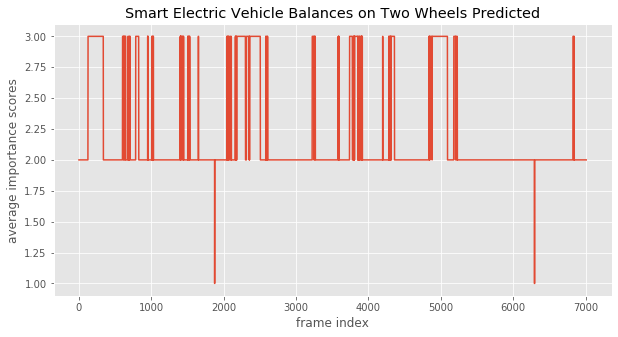

In [181]:
plot_average_importance_scores(np.around(vgg_model_final_predictions[:7010]), 'Smart Electric Vehicle Balances on Two Wheels')

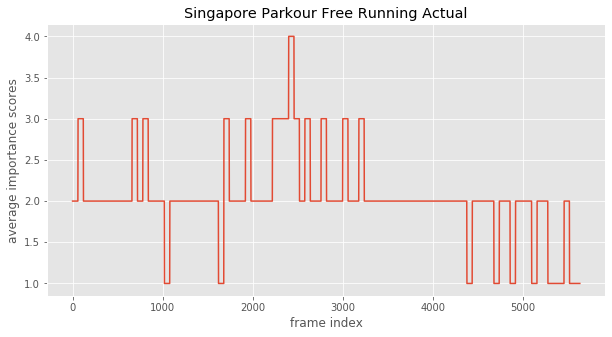

In [177]:
plot_average_importance_scores(np.around(y_test_vgg[7010:12641]), 'Singapore Parkour Free Running Actual')

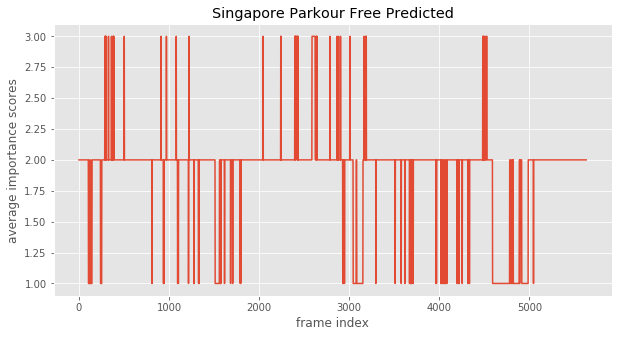

In [178]:
plot_average_importance_scores(np.around(vgg_model_final_predictions[7010:12641]), 'Singapore Parkour Free Predicted')

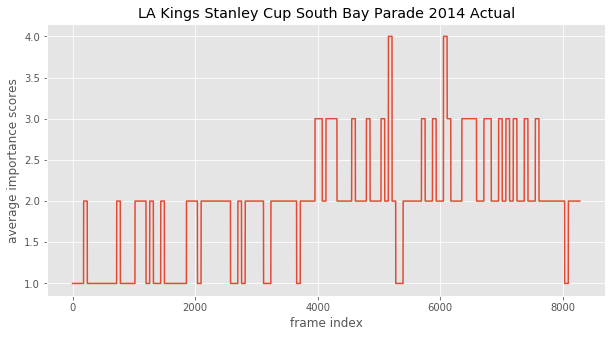

In [179]:
plot_average_importance_scores(np.around(y_test_vgg[12641:20922]), 'LA Kings Stanley Cup South Bay Parade 2014 Actual')

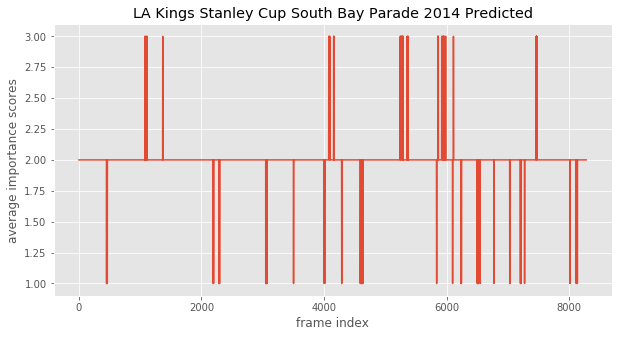

In [180]:
plot_average_importance_scores(np.around(vgg_model_final_predictions[12641:20922]), 'LA Kings Stanley Cup South Bay Parade 2014 Predicted')

In [171]:
## PREVIOUS LSTM APPROADCHC WITH RGB AND HSV BELOW -----

# RGB test predictions
X_test_reg_formatted = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
reg_predictions = reg_lstm.model.predict(X_test_reg_formatted)

NameError: name 'X_test' is not defined

In [ ]:
reg_predictions[[17, 500, 2000, 2200, 2800, 39000, 50000, 60000]]

In [883]:
y_test_std[[17, 500, 2000, 2200, 2800, 39000, 50000, 60000]]

array([[0.5060241 ],
       [0.37349398],
       [0.28915663],
       [0.71084337],
       [0.40963855],
       [0.68674699],
       [0.3373494 ],
       [0.60240964]])

In [820]:
# HSV test predictions
X_test_reg_formatted_hsv = np.reshape(X_test_hsv, (X_test_hsv.shape[0], 1, X_test_hsv.shape[1]))
reg_predictions_hsv = reg_lstm.model.predict(X_test_reg_formatted_hsv)

In [852]:
# RGB train predictions
X_train_reg_formatted = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
reg_predictions_train = reg_lstm.model.predict(X_train_reg_formatted)

In [821]:
# HSV train predictions 
X_train_reg_formatted_hsv = np.reshape(X_train_hsv, (X_train_hsv.shape[0], 1, X_train_hsv.shape[1]))
reg_predictions_train_hsv = reg_lstm.model.predict(X_train_reg_formatted_hsv)

In [857]:
# RGB Train Errors
np.sqrt(mean_squared_error(y_train_std, reg_predictions_train)), r2_score(y_train_std, reg_predictions_train)

(0.11067655724757314, 0.20855102169363315)

In [884]:
# HSV Train Errors
np.sqrt(mean_squared_error(y_train_hsv, reg_predictions_train_hsv)), r2_score(y_train_hsv, reg_predictions_train_hsv)

(0.5139523487772597, 0.15718487094341393)

In [885]:
# RGB Test Errors
np.sqrt(mean_squared_error(y_test_std, reg_predictions)), r2_score(y_test_std, reg_predictions)

(0.1546255851858243, -0.27669402517050945)

In [886]:
# HSV Test Errors
np.sqrt(mean_squared_error(y_test_hsv, reg_predictions_hsv)), r2_score(y_test_hsv, reg_predictions_hsv)

(1.0848855695758526, -2.6491841939537633)

In [877]:
threes = np.array([3]*74575).reshape(-1, 1)

In [887]:
# HSV Test Errors
np.sqrt(mean_squared_error(y_test_hsv, threes)), r2_score(y_test_hsv, threes)

(1.1869835309651242, -3.3683487835127934)

In [2]:
def plot_average_importance_scores(avg_scores, title):
  fig, ax = plt.subplots(figsize=(10, 5))
  x = range(len(avg_scores))
  ax.set_xlabel('frame index')
  ax.set_ylabel('average importance scores')
  ax.set_title(title)
  ax.plot(x, avg_scores)

In [34]:
'test'

'test'